In [233]:
import torch
import models
from sklearn.neighbors import DistanceMetric
from utils import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import train
import myexman
import os
from dfd_utils.FaceForensicsDataset import FaceForensicsDataset
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
import yaml
from dfd_utils.utils import plot_images, plot_embeddings_2D, plot_embeddings_3D
import pandas as pd
from argparse import Namespace
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
plt.rcParams['figure.dpi']=300
device = torch.device('cuda')


# Compare the perfomance of the linear classifier to that of the KNN algorithm:
specifically we wanted to test the ability to detect different types of deepfake manipulations even ones not used in training
We want to evaluate these two method using 3 different encoders to create the latent space - SimCLR with the original augmentations, SimCLR with the new FF oriented augmentations and a ResNet-50 pretrained on ImageNet (no contrastive training)


## Load models:

In [239]:
trained_models_folder = '/media/shirbar/My Passport/trained_models/'
DEVICE = torch.device('cuda')
def load_eval_model(eval_model_path, encoder_path):
    ckpt = torch.load(eval_model_path, map_location= DEVICE)
    ckpt['hparams'].deepfakes = False # don't put deepfakes in the train set
    ckpt['hparams'].encoder_ckpt = encoder_path
    model = models.ssl.SSLEval.load(ckpt, device=DEVICE)
    model.encoder.eval()
    model.eval()
    return model

model_path = '/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/logs/exman-train.py/runs/000213/checkpoint-28000.pth.tar'#os.path.join(trained_models_folder,'linear_evals',
             #                    'linear_eval_original_augs_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_original_augs_pretrained_resnet.pth.tar')
original_aug_model = load_eval_model(model_path, encoder_path)


model_path = '/media/shirbar/DATA/Deep_Learning/Project/Azure_results/000028 - classifier new_augs pretrained/checkpoint-28000.pth.tar'#os.path.join(trained_models_folder,'linear_evals',
              #                   'linear_eval_new_augs_pretrained_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_new_augs_pretrained_only_real.pth.tar')
new_aug_model = load_eval_model(model_path, encoder_path)

model_path = '/media/shirbar/DATA/Deep_Learning/Project/Azure_results/000004 - linear eval divided no pretrain/checkpoint-28000.pth.tar'#os.path.join(trained_models_folder,'linear_evals',
              #                   'linear_eval_new_augs_no_pretrain_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_new_transforms_real_epoch_11000.pth.tar')
new_aug_no_pre_model = load_eval_model(model_path, encoder_path)


resnet_path = '/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/logs/exman-train.py/runs/000216/checkpoint-28000.pth.tar'#os.path.join(trained_models_folder,'linear_evals',
              #                   'linear_eval_resnet_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                                   'andrew_resnet.pth.tar')
resnet_model = load_eval_model(model_path, encoder_path)


no path to faceforensics, using path from passed path...
no path to faceforensics, using path from passed path...
** Removing original FC layer **
** Using avgpool **
** Loading pretrained ResNet50 weights **
======> Encoder: output dim 2048 | 23.508M parameters
no path to faceforensics, using path from passed path...
no path to faceforensics, using path from passed path...
** Removing original FC layer **
** Using avgpool **
** Loading pretrained ResNet50 weights **
======> Encoder: output dim 2048 | 23.508M parameters
no path to faceforensics, using path from passed path...
no path to faceforensics, using path from passed path...
** Removing original FC layer **
** Using avgpool **
======> Encoder: output dim 2048 | 23.508M parameters
no path to faceforensics, using path from passed path...
no path to faceforensics, using path from passed path...
** Removing original FC layer **
** Using avgpool **
** Loading pretrained ResNet50 weights **
======> Encoder: output dim 2048 | 23.508M p

# Load train dataset and create/load embeddings:
creating the embeddings may take some time, you can optionally upload them from a saved file

In [240]:
# the train set images are the same for all models so we can just load the train set once:
original_aug_model.prepare_data()
train_loader, test_loader = original_aug_model.dataloaders()
train_loader.dataset.dataset.dataset.transform = test_loader.dataset.dataset.dataset.transform

preparing data
calling transforms from SSLeval class
importing FF
FF train dir: /media/shirbar/My Passport/FaceForensics/split_ds/train
FF test dir: /media/shirbar/My Passport/FaceForensics/split_ds/test
** Using original SimCLR transforms
Compose(
    CenterCropAndResize(proportion=0.95, size=224)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    <function SSLEval.transforms.<locals>.<lambda> at 0x7f7a7f562a60>
)
loading real images...
real images loaded!
real imgs len: 366831
masks len: 366831
fakes imgs len: 0
fakes masks len: 0
final imgs len: 366831
final masks len: 366831
asserting order
assertion passed!
loading real images...
real images loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 0
fakes masks len: 0
final imgs len: 73768
final masks len: 73768
asserting order
assertion passed!
Train size: 28000
Test size: 4000


In [241]:
# Calculate embeddings:
@torch.no_grad()
def get_embeds(model, loader, div=True):
    embeds = []
    if div:
        div_embeds = []
    targets = []
    counter=0
    for image, _, target in tqdm(loader):
        image = image.to(device)
        if counter==0:
            print(f'before: {image.max()}, {image.min()}')
        embeds.append(model.encode(image))
        if div:
            image = image/255.
            if counter==0:
                print(f'after: {image.max()}, {image.min()}')
            div_embeds.append(model.encode(image))
        targets.append(target)
        counter+=1
    
    embeds = torch.vstack(embeds)
    targets = torch.hstack(targets)
    if div:
        div_embeds = torch.vstack(div_embeds)
        return embeds.cpu(), div_embeds.cpu(), targets.cpu()
    return embeds.cpu(), targets.cpu()


In [242]:
_, original_aug_train_embeds, train_targets = get_embeds(original_aug_model, train_loader)
_, new_aug_train_embeds, _ = get_embeds(new_aug_model, train_loader)
_, new_aug_no_pre_train_embeds, _ = get_embeds(new_aug_no_pre_model, train_loader)
_, resnet_train_embeds,_ = get_embeds(resnet_model, train_loader)


  0%|          | 1/875 [00:34<8:26:59, 34.80s/it]

before: 255, 0
after: 1.0, 0.0


  0%|          | 3/875 [00:02<23:15,  1.60s/it]

before: 255, 0
after: 1.0, 0.0


  0%|          | 3/875 [00:02<22:20,  1.54s/it]

before: 255, 0
after: 1.0, 0.0


  0%|          | 3/875 [00:02<20:21,  1.40s/it]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 875/875 [01:40<00:00,  8.71it/s]


In [6]:
# save your embeddings if you wish:
torch.save({'embeddings': original_aug_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/original_augs_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_all_train_set_embeds_real.pt')
torch.save({'embeddings': resnet_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/resnet_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_no_pre_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_no_pre_train_embeds2, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real2.pt')


NameError: name 'original_aug_train_embeds' is not defined

## alternatively you can load the embeddings we used from file:

In [179]:
org_aug_path = '/media/shirbar/My Passport/trained_models/embeddings/original_augs_all_train_set_embeds_real.pt'
new_aug_path = '/media/shirbar/My Passport/trained_models/embeddings/new_augs_all_train_set_embeds_real.pt'
new_aug_no_pre_path = '/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt'
new_aug_no_pre_path2 = '/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt'
resnet_path = '/media/shirbar/My Passport/trained_models/embeddings/resnet_all_train_set_embeds_real.pt'

chkpt = torch.load(org_aug_path)
original_aug_train_embeds, train_targets = chkpt['embeddings'], chkpt['targets']
chkpt = torch.load(new_aug_path)
new_aug_train_embeds = chkpt['embeddings']
chkpt = torch.load(new_aug_no_pre_path)
new_aug_no_pre_train_embeds = chkpt['embeddings']
chkpt = torch.load(new_aug_no_pre_path2)
new_aug_no_pre_train_embeds2 = chkpt['embeddings']
chkpt = torch.load(resnet_path)
resnet_train_embeds = chkpt['embeddings']

# Function to create a custom test loader:

In [243]:
def load_ff_ds_test(wanted_ds_size,
                    batch_size,
                    load_deepfakes=False,
                    load_face2face=False,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=None,
                   split='test'):
    TEST_DATASET_PATH = f'/media/shirbar/My Passport/FaceForensics/split_ds/{split}'
    ff_ds_test  = FaceForensicsDataset(TEST_DATASET_PATH,
                                    transform=transform,
                                    load_deepfakes=load_deepfakes,
                                    load_face2face=load_face2face,
                                    load_neural_textures=load_neural_textures,
                                  masking_transforms=masking_transforms)
    
    ff_ds_test.equalize_real_fakes()
    #"""
    if wanted_ds_size != -1:
        test_size = int(0.8 * len(ff_ds_test))
        ts_size = len(ff_ds_test) - test_size

        test_dataset,_ = torch.utils.data.random_split(ff_ds_test, [test_size, ts_size], generator=torch.Generator().manual_seed(42))
        test_subset = Subset(test_dataset, list(range(0, wanted_ds_size)))
    else:
        test_subset = ff_ds_test
    #"""
    """
    ff_ds_test_len = len(ff_ds_test)
    wanted_ds_size = wanted_ds_size if ff_ds_test_len > wanted_ds_size else ff_ds_test_len
    random.seed(42)
    random_indices = random.sample(range(0,ff_ds_test_len), wanted_ds_size)

    test_subset = Subset(ff_ds_test, random_indices)
    """
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle = False)

    print('test size:', test_subset.__len__())
    return test_loader

# Model evaluation function for the linear classifier:

In [244]:

@torch.no_grad()
def eval_model_classification(model,h,targets):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    h = h.to(device)
    targets = targets.to(device)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pred = model(h.to(device))
    pred = F.softmax(pred,dim=1)
    pred_classes = torch.argmax(pred, dim=1)
    total_correct = (pred_classes==targets).sum()
    acc = total_correct / len(targets) * 100
    print('\ntotal real:', targets.sum(), ' total fake:', len(targets) - targets.sum())
    print('\nPREDS:\n', pred_classes,'\nTARGETS:\n',targets)
    print('total correct:', total_correct, ' out of:', len(targets))
    print(f'\nACC: {acc}')
    return acc, pred_classes, targets

# Functions for KNN based classifier:
after https://arxiv.org/abs/2002.10445, the semi supervised setting

In [245]:
# make sure to run the get_embeds cell a few cells up

def get_train_knns(train_embeds, k=3,p=2):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto',p=p).fit(train_embeds) 
    train_knns, _ = nbrs.kneighbors(train_embeds)
    train_knns = train_knns[:,1:] # remove first column as it is only zeros (each vector's dist to itself)
    nbrs.n_neighbors = k # return back to k, the test vecs won't be in the train set 
    return nbrs, train_knns

def get_test_knns(train_neighbors,test_embeds,k=3):
    assert train_neighbors.n_neighbors == k
    test_knns, _ = train_neighbors.kneighbors(test_embeds.cpu())
    return test_knns

def eval_model_knns(test_embeds, test_targets, train_neighbors, train_knns,k=3):
    test_knns = get_test_knns(train_neighbors,test_embeds,k)
    # Note: the paper didn't specify how/what was their thresholding for the KNN distances, so we 
    # selected to use the 95th quantile of the KNN distances of the training data, additional tuning on the
    # validation set will probably yield better results.
    thresh = np.quantile(test_knns,0.44) 
    # real has a label of 1 so anything below the thresh should be labelled 1:
    predictions = (test_knns.mean(axis=1)<thresh).astype(int) 
    predictions = torch.Tensor(predictions)
    total_correct = (predictions==test_targets).sum()
    acc = total_correct / len(test_knns) * 100
    return acc, predictions, test_targets, thresh



# Load test sets:

In [246]:
TEST_SIZE = 6000
TRANSFORMS = test_loader.dataset.dataset.dataset.transform#all classifiers have the same transforms
split='test'

dpfk_test_loader = load_ff_ds_test(wanted_ds_size=TEST_SIZE,
                    batch_size=16,
                    load_deepfakes=True,
                    load_face2face=False,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=TRANSFORMS,
                    split=split) 
f2f_test_loader = load_ff_ds_test(wanted_ds_size=TEST_SIZE,
                    batch_size=16,
                    load_deepfakes=False,
                    load_face2face=True,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=TRANSFORMS,
                    split=split)
nt_test_loader = load_ff_ds_test(wanted_ds_size=TEST_SIZE,
                    batch_size=16,
                    load_deepfakes=False,
                    load_face2face=False,
                    load_neural_textures=True,
                    masking_transforms=False,
                    transform=TRANSFORMS,
                    split=split)


loading real images...
real images loaded!
loading deepfakes...
deepfakes loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 6000
loading real images...
real images loaded!
loading face2face...
face2face loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 6000
loading real images...
real images loaded!
loading neural textures...
neural textures loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 56951
fakes masks len: 56951
final imgs len: 130719
final masks len: 130719
asserting order
assertion passed!
before eq: real: 73768  fake: 56951  total: 130719
after eq: total: 

# And finally, inference!
note: calculating the KNN for the train embeddings takes a while

In [247]:
K = 21 # choose a K for the KNN algorithm, paper says 2 performs slightly better however not much variability in performance
loaders = {'deepfake' : dpfk_test_loader,
           'f2f' : f2f_test_loader, 
           'nt' : nt_test_loader}
models = {'original_augs' : original_aug_model, 
          'new_augs' : new_aug_model,
          'new_augs_no_pre' : new_aug_no_pre_model,
          #'new_augs_no_pre2' : new_aug_no_pre_model2, 
          'resnet':resnet_model}
embeds_dict = {'original_augs' : original_aug_train_embeds, 
               'new_augs': new_aug_train_embeds, 
               'new_augs_no_pre' : new_aug_no_pre_train_embeds,
               #'new_augs_no_pre2' : new_aug_no_pre_train_embeds2,
               'resnet':resnet_train_embeds}
results_df = pd.DataFrame(columns=['model_name', 'deepfake_method',
                                   'classification_accuracy', 'knn_accuracy',
                                  'knn_dist_threshold','train_size','test_size'])
for model_name, model in models.items():
    train_embeds = embeds_dict[model_name]
    train_embeds = train_embeds[train_targets==1] #we use only "normal" aka real samples for the train set
    print(f'Calculating KNNs on {model_name} model embeddings')
    # get the sklearn Nearest Neighbor calculator and the KNN distances of the train set, the latter will be used
    # for thresholding the test set to determine "anomalies" aka fake samples:
    train_nn, train_knns = get_train_knns(train_embeds.cpu(), k=K)  
    for loader_name, loader in loaders.items():
        print(f'Getting test embeddings')
        undiv_embeds, test_embeds,test_targets = get_embeds(model,loader,div=True)
        print(f'Performing linear eval on {loader_name}')
        if model_name=='new_augs_no_pre2':
            c_acc,c_pred,c_tar = eval_model_classification(model,undiv_embeds,test_targets)
        else:
            c_acc,c_pred,c_tar = eval_model_classification(model,test_embeds,test_targets)
        print(f'Calculating {loader_name} KNNs')
        k_acc,k_pred,k_tar,k_thresh = eval_model_knns(test_embeds, test_targets, train_nn, train_knns,k=K)
        print(f'model: {model_name}, manipulation: {loader_name}, linear eval accuracy: {c_acc:.2f}, knn accuracy: {k_acc:.2f}')
        results_df = results_df.append({'model_name' : model_name, 
                                        'deepfake_method' : loader_name,
                                        'classification_accuracy' : c_acc, 
                                        'knn_accuracy' : k_acc,
                                       'knn_dist_threshold':k_thresh,
                                       'train_size': len(train_knns),
                                       'test_size': len(loader.dataset)}, ignore_index=True)
        
results_path = '/media/shirbar/DATA/Deep_Learning/Project/knn_linear_eval_comparison_test_divided_k21_28THITER.csv'
results_df.to_csv(results_path)
print(f'Saved results to file at {results_path}')

Calculating KNNs on original_augs model embeddings


  0%|          | 0/375 [00:00<?, ?it/s]

Getting test embeddings


  0%|          | 1/375 [00:00<03:54,  1.60it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [08:36<00:00,  1.38s/it]


Performing linear eval on deepfake

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(5956, device='cuda:0')  out of: 6000

ACC: 99.26666259765625
Calculating deepfake KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: original_augs, manipulation: deepfake, linear eval accuracy: 99.27, knn accuracy: 69.32
Getting test embeddings


  0%|          | 1/375 [00:00<02:38,  2.36it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [07:02<00:00,  1.13s/it]


Performing linear eval on f2f

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(3043, device='cuda:0')  out of: 6000

ACC: 50.71666717529297
Calculating f2f KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: original_augs, manipulation: f2f, linear eval accuracy: 50.72, knn accuracy: 45.32
Getting test embeddings


  0%|          | 1/375 [00:01<11:38,  1.87s/it]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [11:40<00:00,  1.87s/it]


Performing linear eval on nt

total real: tensor(3436, device='cuda:0')  total fake: tensor(2564, device='cuda:0')

PREDS:
 tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(3692, device='cuda:0')  out of: 6000

ACC: 61.53333282470703
Calculating nt KNNs
model: original_augs, manipulation: nt, linear eval accuracy: 61.53, knn accuracy: 52.02
Calculating KNNs on new_augs model embeddings


  0%|          | 0/375 [00:00<?, ?it/s]

Getting test embeddings


  0%|          | 1/375 [00:00<03:23,  1.84it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [02:57<00:00,  2.11it/s]


Performing linear eval on deepfake

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 0, 0,  ..., 0, 0, 0], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(5095, device='cuda:0')  out of: 6000

ACC: 84.91666412353516
Calculating deepfake KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: new_augs, manipulation: deepfake, linear eval accuracy: 84.92, knn accuracy: 45.83
Getting test embeddings


  0%|          | 1/375 [00:00<02:29,  2.49it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [03:00<00:00,  2.08it/s]


Performing linear eval on f2f

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 1, 0,  ..., 1, 0, 0], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(3710, device='cuda:0')  out of: 6000

ACC: 61.833335876464844
Calculating f2f KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: new_augs, manipulation: f2f, linear eval accuracy: 61.83, knn accuracy: 53.82
Getting test embeddings


  0%|          | 1/375 [00:00<02:45,  2.26it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [02:55<00:00,  2.13it/s]


Performing linear eval on nt

total real: tensor(3436, device='cuda:0')  total fake: tensor(2564, device='cuda:0')

PREDS:
 tensor([0, 0, 0,  ..., 1, 1, 0], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(4142, device='cuda:0')  out of: 6000

ACC: 69.03333282470703
Calculating nt KNNs
model: new_augs, manipulation: nt, linear eval accuracy: 69.03, knn accuracy: 49.97
Calculating KNNs on new_augs_no_pre model embeddings


  0%|          | 0/375 [00:00<?, ?it/s]

Getting test embeddings


  0%|          | 1/375 [00:00<03:32,  1.76it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [02:59<00:00,  2.09it/s]


Performing linear eval on deepfake

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(5888, device='cuda:0')  out of: 6000

ACC: 98.13333129882812
Calculating deepfake KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: new_augs_no_pre, manipulation: deepfake, linear eval accuracy: 98.13, knn accuracy: 73.60
Getting test embeddings


  0%|          | 1/375 [00:00<02:28,  2.51it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [02:58<00:00,  2.10it/s]


Performing linear eval on f2f

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 0, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(4014, device='cuda:0')  out of: 6000

ACC: 66.89999389648438
Calculating f2f KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: new_augs_no_pre, manipulation: f2f, linear eval accuracy: 66.90, knn accuracy: 60.33
Getting test embeddings


  0%|          | 1/375 [00:00<02:42,  2.30it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [02:57<00:00,  2.11it/s]


Performing linear eval on nt

total real: tensor(3436, device='cuda:0')  total fake: tensor(2564, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 0, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(4371, device='cuda:0')  out of: 6000

ACC: 72.8499984741211
Calculating nt KNNs
model: new_augs_no_pre, manipulation: nt, linear eval accuracy: 72.85, knn accuracy: 61.43
Calculating KNNs on resnet model embeddings


  0%|          | 0/375 [00:00<?, ?it/s]

Getting test embeddings


  0%|          | 1/375 [00:00<03:30,  1.77it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [02:55<00:00,  2.14it/s]


Performing linear eval on deepfake

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(3566, device='cuda:0')  out of: 6000

ACC: 59.43333435058594
Calculating deepfake KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: resnet, manipulation: deepfake, linear eval accuracy: 59.43, knn accuracy: 71.85
Getting test embeddings


  0%|          | 1/375 [00:00<02:27,  2.53it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [03:00<00:00,  2.08it/s]


Performing linear eval on f2f

total real: tensor(3029, device='cuda:0')  total fake: tensor(2971, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
total correct: tensor(3052, device='cuda:0')  out of: 6000

ACC: 50.86666488647461
Calculating f2f KNNs


  0%|          | 0/375 [00:00<?, ?it/s]

model: resnet, manipulation: f2f, linear eval accuracy: 50.87, knn accuracy: 54.15
Getting test embeddings


  0%|          | 1/375 [00:00<02:44,  2.27it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [02:56<00:00,  2.12it/s]


Performing linear eval on nt

total real: tensor(3436, device='cuda:0')  total fake: tensor(2564, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 0, 0,  ..., 0, 1, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(3459, device='cuda:0')  out of: 6000

ACC: 57.650001525878906
Calculating nt KNNs
model: resnet, manipulation: nt, linear eval accuracy: 57.65, knn accuracy: 54.30
Saved results to file at /media/shirbar/DATA/Deep_Learning/Project/knn_linear_eval_comparison_test_divided_k21_28THITER.csv


In [205]:
#results_df.classification_accuracy = results_df.classification_accuracy.apply(lambda x: x.item())
results_df
results_df.to_csv(results_path)


In [206]:
### Check our winning model - new_augs_no_pre on allllll the test set, start by loading the test sets:
TEST_SIZE = -1
TRANSFORMS = test_loader.dataset.dataset.dataset.transform #all classifiers have the same transforms
split='test'

dpfk_test_loader = load_ff_ds_test(wanted_ds_size=TEST_SIZE,
                    batch_size=16,
                    load_deepfakes=True,
                    load_face2face=False,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=TRANSFORMS,
                    split=split) 
f2f_test_loader = load_ff_ds_test(wanted_ds_size=TEST_SIZE,
                    batch_size=16,
                    load_deepfakes=False,
                    load_face2face=True,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=TRANSFORMS,
                    split=split)
nt_test_loader = load_ff_ds_test(wanted_ds_size=TEST_SIZE,
                    batch_size=16,
                    load_deepfakes=False,
                    load_face2face=False,
                    load_neural_textures=True,
                    masking_transforms=False,
                    transform=TRANSFORMS,
                    split=split)


loading real images...
real images loaded!
loading deepfakes...
deepfakes loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 147536
loading real images...
real images loaded!
loading face2face...
face2face loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 147536
loading real images...
real images loaded!
loading neural textures...
neural textures loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 56951
fakes masks len: 56951
final imgs len: 130719
final masks len: 130719
asserting order
assertion passed!
before eq: real: 73768  fake: 56951  total: 130719
after eq: tot

In [223]:
# Now let's do some inferring:
K = 21
#all_test_results_df = pd.DataFrame(columns=['model_name','deepfake_method',
#                                   'classification_accuracy', 'knn_accuracy',
#                                  'knn_dist_threshold','train_size','test_size'])
#loaders = {'deepfake' : dpfk_test_loader, 'f2f' : f2f_test_loader, 'nt' : nt_test_loader}
loaders = {'f2f' : f2f_test_loader, 'nt' : nt_test_loader}
model = new_aug_no_pre_model
model_name = 'new_augs_no_pre'
model2 = new_aug_no_pre_model2
model_name2 = 'new_augs_no_pre2'
train_embeds = new_aug_no_pre_train_embeds
train_embeds = train_embeds[train_targets==1] # only real data in the trainset
#train_embeds2, tr = get_embeds(new_aug_no_pre_model2, train_loader,div=False)
train_embeds2 = train_embeds2[train_targets==1] # only real data in the trainset

#print(f'Calculating KNNs on {model_name} model embeddings')
#train_nn, train_knns = get_train_knns(train_embeds, k=K)  
#train_nn2, train_knns2 = get_train_knns(train_embeds2, k=3)  

for loader_name, loader in loaders.items():
    print(f'Performing linear eval on {loader_name}')
    test_embeds2,test_embeds,test_targets = get_embeds(model,loader,div=True)
    c_acc,c_pred,c_tar = eval_model_classification(model,test_embeds, test_targets)
    c_acc2,c_pred2,c_tar2 = eval_model_classification(model2,test_embeds2, test_targets)
    print(f'Calculating {loader_name} KNNs')
    k_acc,k_pred,k_tar,k_thresh = eval_model_knns(test_embeds, test_targets, train_nn, train_knns,k=K)
    k_acc2,k_pred2,k_tar2,k_thresh2 = eval_model_knns(test_embeds2, test_targets, train_nn2, train_knns2,k=3)
    print(f'model_name: {model_name}, manipulation: {loader_name}, linear eval accuracy: {c_acc:.2f}, knn accuracy: {k_acc:.2f}')
    print(f'model_name: {model_name2}, manipulation: {loader_name}, linear eval accuracy: {c_acc:.2f}, knn accuracy: {k_acc:.2f}')
    all_test_results_df = all_test_results_df.append({'model_name' : model_name,
                                        'deepfake_method' : loader_name,
                                        'classification_accuracy' : c_acc, 
                                        'knn_accuracy' : k_acc,
                                       'knn_dist_threshold':k_thresh,
                                       'train_size': len(train_knns),
                                       'test_size': len(loader.dataset)}, ignore_index=True)
    all_test_results_df = all_test_results_df.append({'model_name' : model_name2,
                                        'deepfake_method' : loader_name,
                                        'classification_accuracy' : c_acc2, 
                                        'knn_accuracy' : k_acc2,
                                       'knn_dist_threshold':k_thresh2,
                                       'train_size': len(train_knns2),
                                       'test_size': len(loader.dataset)}, ignore_index=True)
    
results_path = '/media/shirbar/DATA/Deep_Learning/Project/new_aug_no_pretrained_all_test_results.csv'
results_df.to_csv(results_path)
print(f'Saved results to file at {results_path}')

  0%|          | 0/9221 [00:00<?, ?it/s]

Performing linear eval on f2f


  0%|          | 1/9221 [00:05<13:17:16,  5.19s/it]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 9221/9221 [4:16:58<00:00,  1.67s/it]  



total real: tensor(73768, device='cuda:0')  total fake: tensor(73768, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(95669, device='cuda:0')  out of: 147536

ACC: 64.84451293945312

total real: tensor(73768, device='cuda:0')  total fake: tensor(73768, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0') 
TARGETS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(115862, device='cuda:0')  out of: 147536

ACC: 78.53133392333984
Calculating f2f KNNs


  0%|          | 0/8170 [00:00<?, ?it/s]

model_name: new_augs_no_pre, manipulation: f2f, linear eval accuracy: 64.84, knn accuracy: 59.82
model_name: new_augs_no_pre2, manipulation: f2f, linear eval accuracy: 64.84, knn accuracy: 59.82
Performing linear eval on nt


  0%|          | 1/8170 [00:01<3:20:49,  1.48s/it]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 8170/8170 [3:57:43<00:00,  1.75s/it]  



total real: tensor(73768, device='cuda:0')  total fake: tensor(56951, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0') 
TARGETS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(92120, device='cuda:0')  out of: 130719

ACC: 70.4717788696289

total real: tensor(73768, device='cuda:0')  total fake: tensor(56951, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0') 
TARGETS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(104670, device='cuda:0')  out of: 130719

ACC: 80.07252502441406
Calculating nt KNNs
model_name: new_augs_no_pre, manipulation: nt, linear eval accuracy: 70.47, knn accuracy: 60.19
model_name: new_augs_no_pre2, manipulation: nt, linear eval accuracy: 70.47, knn accuracy: 60.19
Saved results to file at /media/shirbar/DATA/Deep_Learning/Project/new_aug_no_pretrained_all_test_results.csv


In [228]:
all_test_results_df
#all_test_results_df.knn_accuracy = all_test_results_df.knn_accuracy.apply(lambda x: x.item())
all_test_results_df
all_test_results_df.to_csv(results_path)

In [214]:
torch.save({'undivided_image_embeddings':test_embeds2,'divided_image_embeddings':test_embeds, 'targets': test_targets},
           '/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_deepfake_test_set_fake_and_real.pt')

In [219]:
c_acc,c_pred,c_tar = eval_model_classification(model,test_embeds, test_targets)
c_acc2,c_pred2,c_tar2 = eval_model_classification(new_aug_no_pre_model2,test_embeds2, test_targets)
k_acc,k_pred,k_tar,k_thresh = eval_model_knns(test_embeds, test_targets, train_nn, train_knns,k=K)
k_acc2,k_pred2,k_tar2,k_thresh2 = eval_model_knns(test_embeds2, test_targets, train_nn2, train_knns2,k=3)


total real: tensor(73768, device='cuda:0')  total fake: tensor(73768, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0') 
TARGETS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(144919, device='cuda:0')  out of: 147536

ACC: 98.2261962890625

total real: tensor(73768, device='cuda:0')  total fake: tensor(73768, device='cuda:0')

PREDS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0') 
TARGETS:
 tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
total correct: tensor(145538, device='cuda:0')  out of: 147536

ACC: 98.645751953125


In [220]:
print(f'model_name: {model_name}, manipulation: {loader_name}, linear eval accuracy: {c_acc:.2f}, knn accuracy: {k_acc:.2f}')
print(f'model_name: {model_name2}, manipulation: {loader_name}, linear eval accuracy: {c_acc:.2f}, knn accuracy: {k_acc:.2f}')
all_test_results_df = all_test_results_df.append({'model_name' : model_name,
                                        'deepfake_method' : loader_name,
                                        'classification_accuracy' : c_acc, 
                                        'knn_accuracy' : k_acc,
                                       'knn_dist_threshold':k_thresh,
                                       'train_size': len(train_knns),
                                       'test_size': len(loader.dataset)}, ignore_index=True)
all_test_results_df = all_test_results_df.append({'model_name' : model_name2,
                                        'deepfake_method' : loader_name,
                                        'classification_accuracy' : c_acc2, 
                                        'knn_accuracy' : k_acc2,
                                       'knn_dist_threshold':k_thresh2,
                                       'train_size': len(train_knns2),
                                       'test_size': len(loader.dataset)}, ignore_index=True)
    

model_name: new_augs_no_pre, manipulation: deepfake, linear eval accuracy: 98.23, knn accuracy: 72.52
model_name: new_augs_no_pre2, manipulation: deepfake, linear eval accuracy: 98.23, knn accuracy: 72.52


NameError: name 'loader_name2' is not defined

In [221]:
all_test_results_df = all_test_results_df.append({'model_name' : model_name2,
                                        'deepfake_method' : loader_name,
                                        'classification_accuracy' : c_acc2, 
                                        'knn_accuracy' : k_acc2,
                                       'knn_dist_threshold':k_thresh2,
                                       'train_size': len(train_knns2),
                                       'test_size': len(loader.dataset)}, ignore_index=True)
    

In [222]:
all_test_results_df

,model_name,deepfake_method,classification_accuracy,knn_accuracy,knn_dist_threshold,train_size,test_size
0,new_augs_no_pre,deepfake,"tensor(98.2262, device='cuda:0')",tensor(72.5152),14.861574,28000,147536
1,new_augs_no_pre2,deepfake,"tensor(98.6458, device='cuda:0')",tensor(78.8242),2173.910859,28000,147536


In [56]:
train_nn_div.kneighbors(div_tests[trs==1]=)

(array([[479.89738835, 507.69401658]]), array([[25083, 13925]]))

In [19]:
test, div_tests, trs = get_embeds(new_aug_no_pre_model, dpfk_test_loader,div=True)

  0%|          | 1/375 [00:00<03:01,  2.06it/s]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 375/375 [03:02<00:00,  2.06it/s]


In [ ]:
div_t

In [38]:
eval_model_knns(test.cpu(), trs, train_nn, train_knns,k=2)

(tensor(80.4833),
 tensor([1., 0., 0.,  ..., 0., 0., 0.]),
 tensor([1, 0, 0,  ..., 0, 1, 1], dtype=torch.int8),
 65204.95803739357)

In [171]:
train_nn_div.n_neighbors = 21
#train_nn_div.p=1
test_knns_div,inds = train_nn_div.kneighbors(div_tests.cpu())

In [162]:
train_nn.n_neighbors = 30
#train_nn_div.p=1
test_knns,inds = train_nn.kneighbors(test.cpu())

In [82]:
test_knns_div[:,:k].shape

(6000, 29)

In [29]:
np.quantile(test_knns_div,0.25)

11.403072834014893

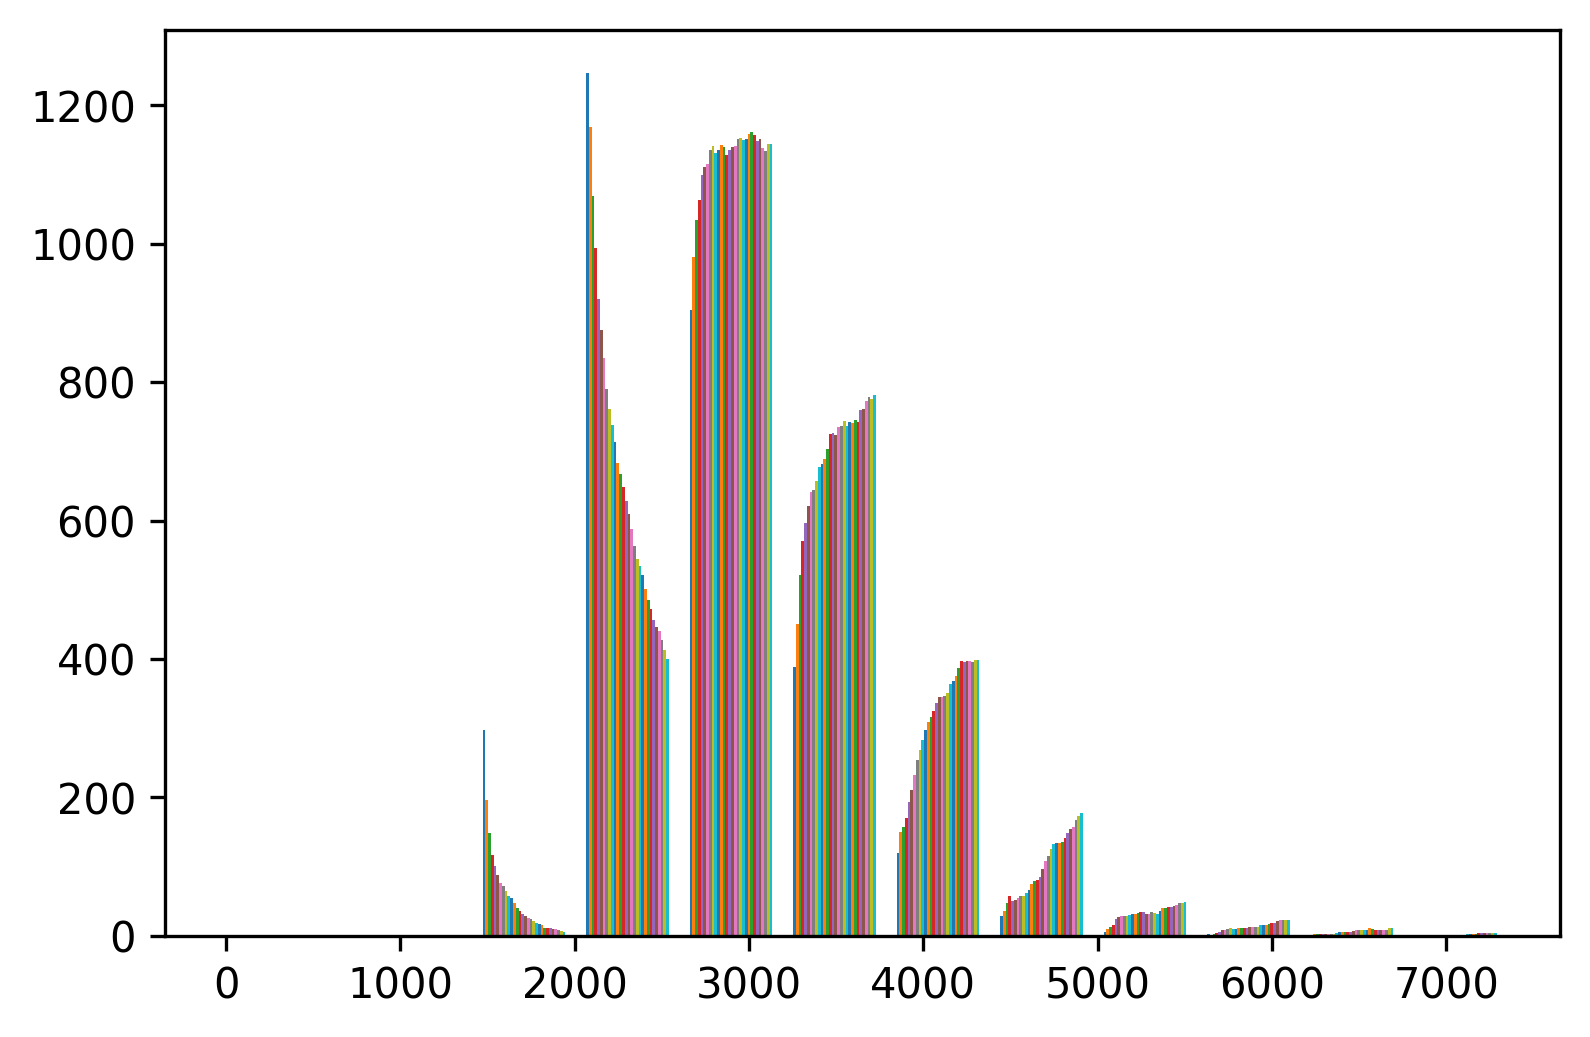

In [164]:
plt.hist(test_knns[trs==0])
#plt.legend(range(30))
plt.plot(np.ones(1200)*np.quantile(test_knns_div,0.25),np.ones(1200),lw=2)
plt.show()

(array([[8.310e+02, 1.566e+03, 4.250e+02, 1.300e+02, 2.800e+01, 8.000e+00,
         1.400e+01, 2.000e+00, 0.000e+00, 0.000e+00],
        [6.020e+02, 1.649e+03, 5.210e+02, 1.730e+02, 3.400e+01, 5.000e+00,
         1.700e+01, 3.000e+00, 0.000e+00, 0.000e+00],
        [4.560e+02, 1.700e+03, 5.730e+02, 2.050e+02, 4.100e+01, 8.000e+00,
         1.600e+01, 4.000e+00, 1.000e+00, 0.000e+00],
        [3.790e+02, 1.693e+03, 6.270e+02, 2.150e+02, 5.500e+01, 1.400e+01,
         1.400e+01, 6.000e+00, 1.000e+00, 0.000e+00],
        [3.110e+02, 1.692e+03, 6.700e+02, 2.270e+02, 6.900e+01, 1.400e+01,
         1.100e+01, 8.000e+00, 2.000e+00, 0.000e+00],
        [2.680e+02, 1.678e+03, 6.950e+02, 2.480e+02, 8.000e+01, 1.300e+01,
         1.000e+01, 9.000e+00, 3.000e+00, 0.000e+00],
        [2.320e+02, 1.649e+03, 7.440e+02, 2.470e+02, 9.000e+01, 2.000e+01,
         9.000e+00, 9.000e+00, 4.000e+00, 0.000e+00],
        [2.080e+02, 1.615e+03, 7.840e+02, 2.560e+02, 9.800e+01, 2.100e+01,
         8.000e+00, 1.

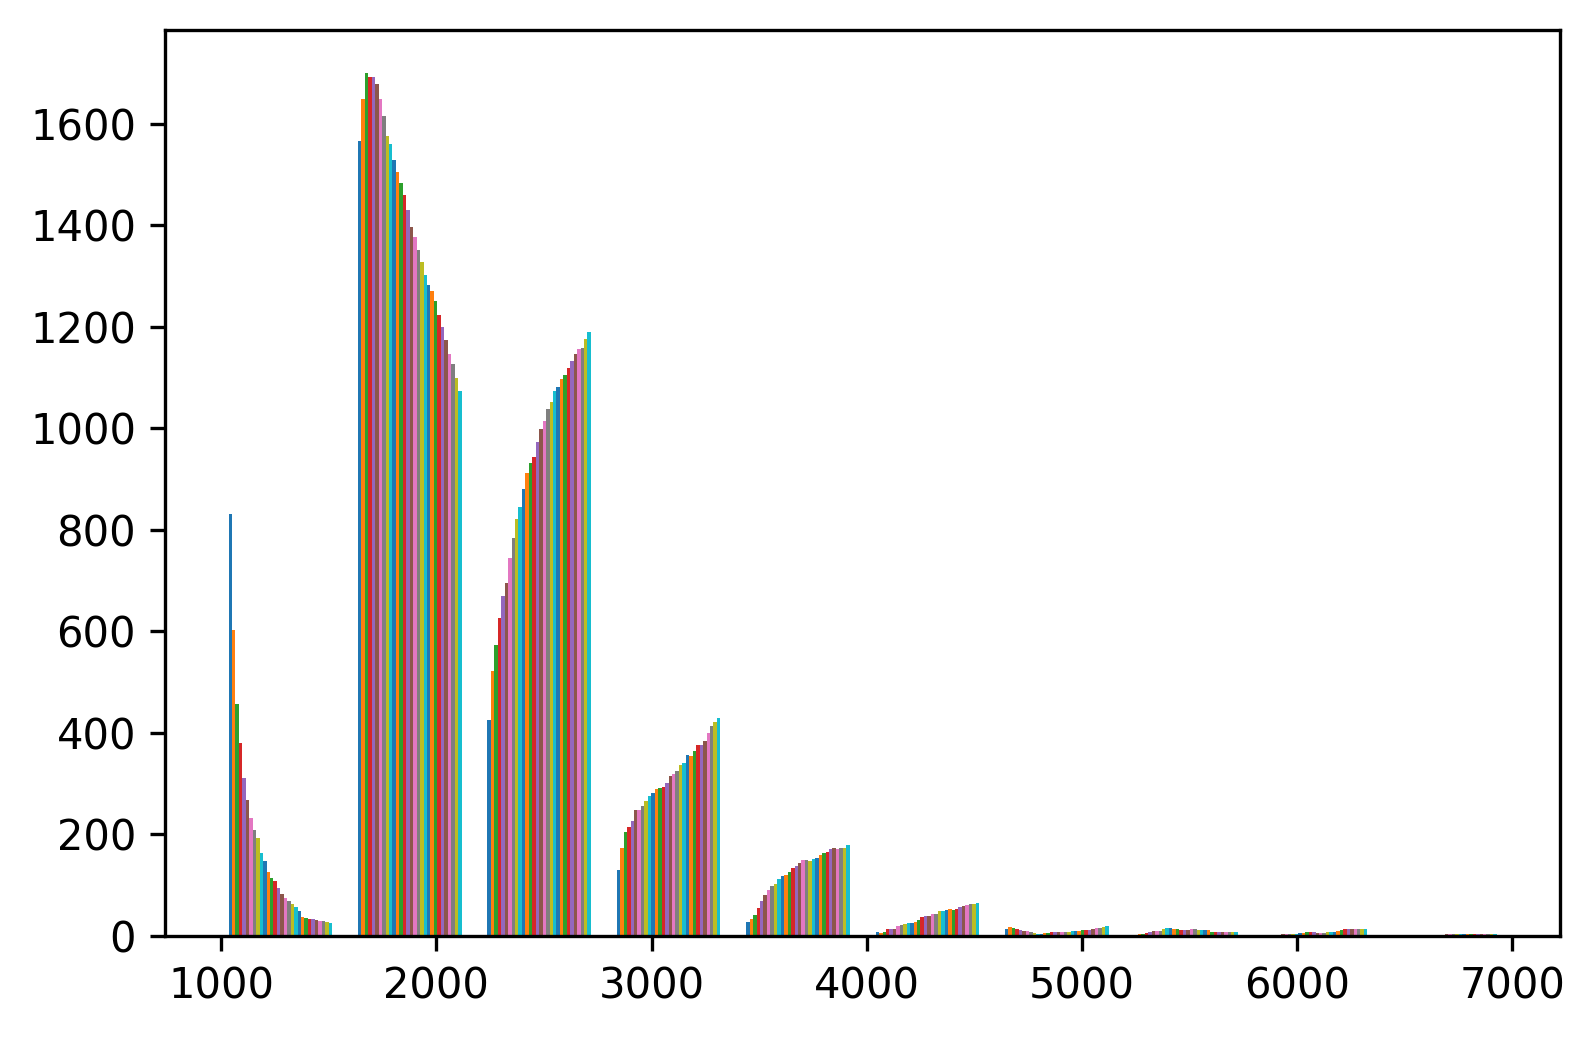

In [166]:
plt.hist(test_knns[trs==1])
#plt.legend(range(20))

In [167]:
undvaccs=[]
for k in range(1,31):
    preds = (test_knns[:,:k].mean(axis=1)<np.quantile(test_knns[:,:k],0.44)).astype(int)#np.quantile(test_knns_div[:,:k],0.44)
    undvaccs.append(((torch.Tensor(preds)==(trs)).sum()/len(trs)).item())


In [177]:
preds = (test_knns_div.mean(axis=1)<np.quantile(test_knns_div,0.44)).astype(int)#np.quantile(test_knns_div[:,:k],0.44)
((torch.Tensor(preds)==(trs)).sum()/len(trs)).item()

0.7393333315849304

In [208]:
undvaccs

[0.8083333373069763,
 0.8116666674613953,
 0.8116666674613953,
 0.8105000257492065,
 0.8078333139419556,
 0.8071666955947876,
 0.8056666851043701,
 0.8043333292007446,
 0.8034999966621399,
 0.8026666641235352,
 0.8028333187103271,
 0.8023333549499512,
 0.8013333082199097,
 0.8003333210945129,
 0.7993333339691162,
 0.7986666560173035,
 0.796999990940094,
 0.79666668176651,
 0.7944999933242798,
 0.793833315372467,
 0.7929999828338623,
 0.7918333411216736,
 0.7911666631698608,
 0.7904999852180481,
 0.7888333201408386,
 0.7885000109672546,
 0.7878333330154419,
 0.7870000004768372,
 0.7864999771118164,
 0.7856666445732117]

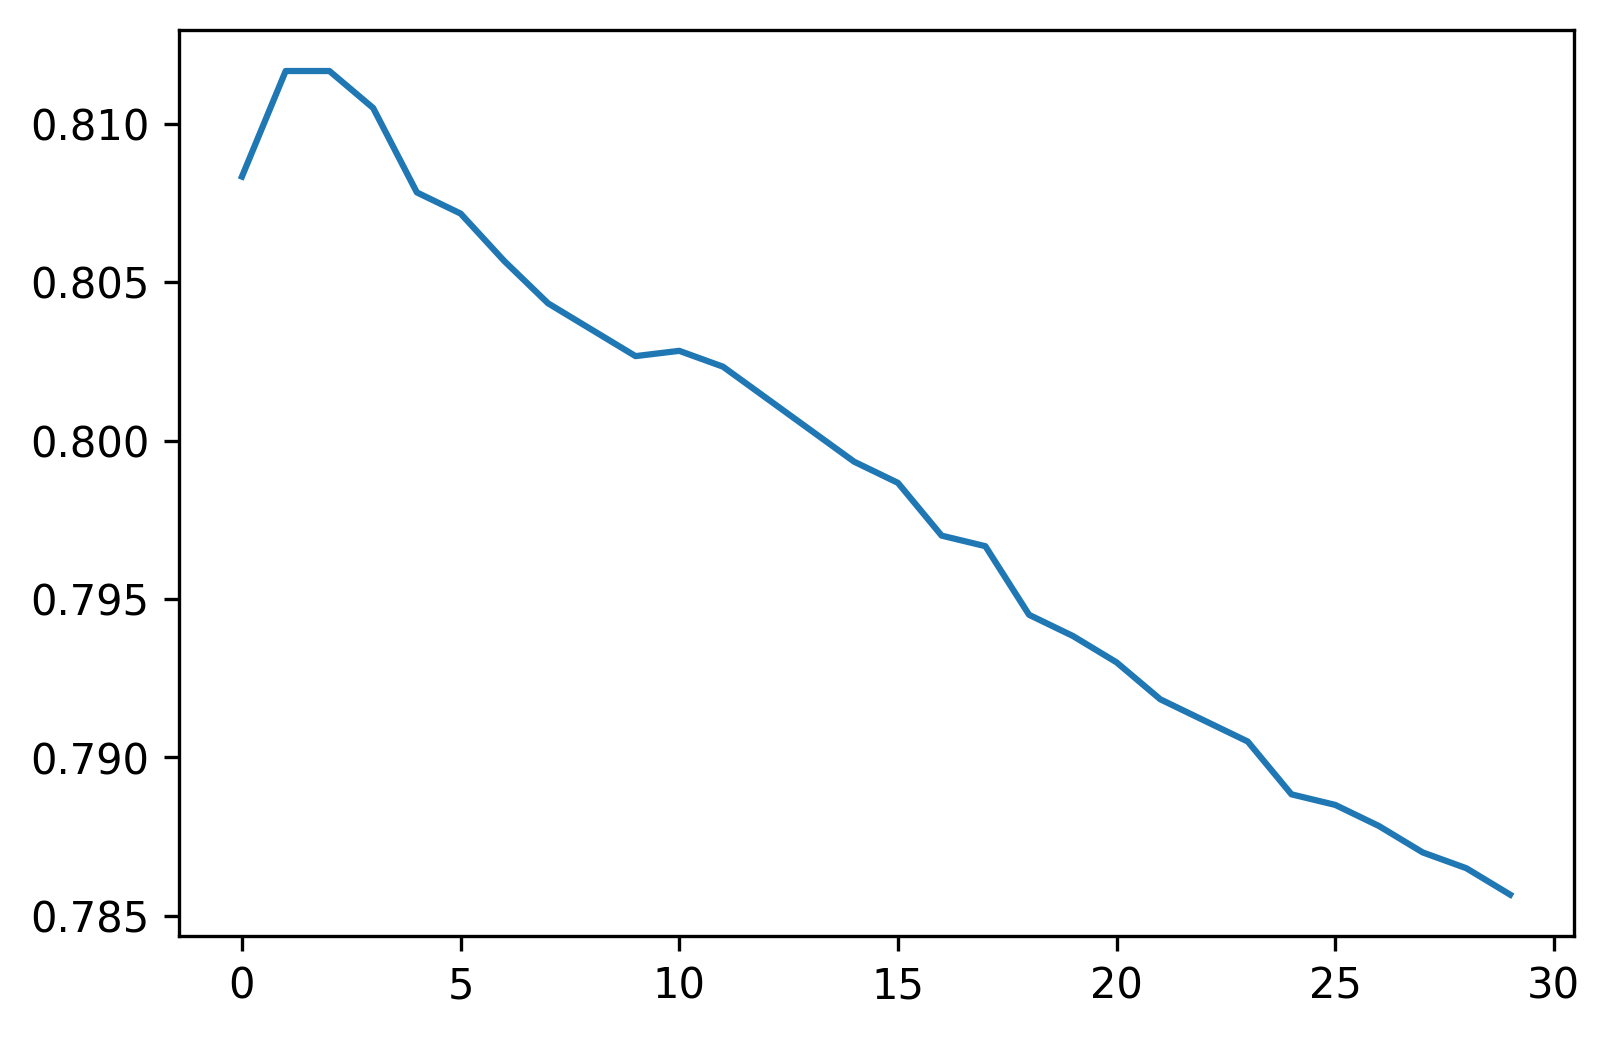

In [169]:
plt.plot(range(30),undvaccs)

In [53]:

train_nn_div, train_knns_div = get_train_knns(div_ts.cpu(), k=K)  


[autoreload of dfd_utils.FaceForensicsDataset failed: Traceback (most recent call last):
  File "/home/shirbar/anaconda3/envs/simclr_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/shirbar/anaconda3/envs/simclr_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/shirbar/anaconda3/envs/simclr_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/shirbar/anaconda3/envs/simclr_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/shirbar/anaconda3/envs/simclr_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/shirbar/anaconda3/envs/simclr_

255255255255  00  

00
255
255  00

255 0
tensor(255, dtype=torch.uint8) tensor(231, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(254, dtype=torch.uint8)tensor(241, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(9, dtype=torch.uint8)    tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(231, dtype=torch.uint8)   tensor(246, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(254, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(9, dtype=torch.uint8)  

 tensor(0, dtype=torch.uint8)tensor(241, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(246, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(231, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
 255tensor(231, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)0

255 0
199 24
255 0
tensor(214, dtype=torch.uint8)tensor(225, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)ten

 tensor(255, dtype=torch.uint8) tensor(246, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
 tensor(14, dtype=torch.uint8)tensor(215, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(246, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8) tensor(218, dtype=torch.uint8)  tensor(14, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 255
0 tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(215, dtype=torch.uint8)   
tensor(218, dtype=torch.uint8)0tensor(0, dtype=torch.uint8)
 
tensor(0, dtype=torch.uint8)
255 0
255 0tensor(155, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(221, dtype=torch.uint8)  tensor(155, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  255tensor(221, dtype=torch.uint8) tensor(0, dtype=torch.uint8)0 

tensor(0, dtype=torch.uint8)
255255 tensor(251, dtype=torch.uint8)tensor(230, dtype=torch.uint8) 00
  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  255tensor(230, dtype=torch.uint8) tensor(251, dtype=tor

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 tensor(255, dtype=torch.uint8)0 255
tensor(0, dtype=torch.uint8) 2552550   0tensor(255, dtype=torch.uint8)
0 

tensor(0, dtype=torch.uint8)
255255255   000


tensor(231, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(231, dtype=torch.uint8)tensor(218, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
  tensor(218, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(239, dtype=torch.uint8)
 tensor(251, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(239, dtype=torch.uint8)tensor(16, dtype=torch.uint8)   tensor(251, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(193, dtype=torch.uint8)tensor(16, dtype=torch.uint8)
 
tensor(0, dtype=torch.uin

tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(218, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(218, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 
tensor(0, dtype=torch.uint8)tensor(210, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(210, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(209, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(209, dtype=torch.uint8)255   tensor(0, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255
 0
255 0
tensor(255, dtype=torch.uint8) tensor(6, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(6, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)255tensor(0, dtype=to

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



255 0
tensor(202, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)255tensor(0, dtype=torch.uint8)   tensor(202, dtype=torch.uint8)tensor(255, dtype=torch.uint8)9 
 tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
 tensor(0, dtype=torch.uint8) tensor(6, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255   tensor(0, dtype=torch.uint8)
0tensor(255, dtype=torch.uint8)
 tensor(6, dtype=torch.uint8)
255 tensor(255, dtype=torch.uint8)4 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255255  2551 
00

255 0
tensor(218, dtype=torch.uint8) tensor(255, dtype=torch.uint8)

  1%|          | 7/875 [00:03<14:03,  1.03it/s]

tensor(12, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(218, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(12, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
tensor(236, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)  tensor(236, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 255  tensor(0, dtype=torch.uint8)0
tensor(255, dtype=torch.uint8)
255  14tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(13, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) 246tensor(13, dtype=torch.uint8) 
0
tensor(253, dtype=torch.uint8) tensor(8, dtype=torch.uint8)tensor(190, dtype=torch.uint8)  tensor(253, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(190, dtype=torch.uint8)tensor(8, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)tensor(193, dtype=torch.uint8)255
  tensor(0, dtype=torch.uint8)0 
tensor(193, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(23, dtype=torch.uint8) tensor(255,

tensor(0, dtype=torch.uint8)tensor(211, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(252, dtype=torch.uint8)255  tensor(211, dtype=torch.uint8)tensor(21, dtype=torch.uint8)0  tensor(252, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(21, dtype=torch.uint8)

255 2550 
0
255 0
255255  0
0
255tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(214, dtype=torch.uint8) 0  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)  tensor(214, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)

 tensor(0, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torc

tensor(0, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) tensor(2, dtype=torch.uint8) tensor(255, dtype=torch.uint8)255  0tensor(2, dtype=torch.uint8)

tensor(234, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(234, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(219, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
255tensor(219, dtype=torch.uint8) 0 
tensor(0, dtype=torch.uint8)
tensor(206, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0255
 tensor(206, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8)tensor(230, dtype=torch.uint8)  tensor(250, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255 tensor(0, dtype=torch.uint8)  0 tensor(230, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(250, dtype=torch.uint8)

  1%|          | 9/875 [00:04<12:22,  1.17it/s]

255 0
255 0
255 0
255 0255
 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255tensor(255, dtype=torch.uint8) tensor(229, dtype=torch.uint8)0  
tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(229, dtype=torch.uint8)tensor(255, dtype=torch.uint8)    tensor(255, dtype=torch.uint8)tensor(213, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8) 
tensor(236, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)  255 tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(213, dtype=torch.uint8)
 0 tensor(236, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
255tensor(242, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)tensor(1, dtype=torch.uint8)
  tensor(242, dtype=tor

  1%|          | 10/875 [00:04<09:27,  1.52it/s]

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(186, dtype=torch.uint8)255255   255tensor(254, dtype=torch.uint8)tensor(0, dtype=torch.uint8)00 
tensor(186, dtype=torch.uint8)
tensor(254, dtype=torch.uint8)255   tensor(5, dtype=torch.uint8)0tensor(0, dtype=torch.uint8) 

  tensor(5, dtype=torch.uint8)0

tensor(237, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(237, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
255255  tensor(0, dtype=torch.uint8)  10tensor(255, dtype=torch.uint8)

 tensor(0, dtype=torch.uint8)
255255  00

tensor(213, dtype=torch.uint8) tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(2, dtype=torch.uint8)  tensor(213, dtype=torch.uint8)tensor(240, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(2, dtype=torch.

  1%|▏         | 12/875 [00:04<06:55,  2.08it/s]

tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255 0
255 0255
 0
255 0tensor(255, dtype=torch.uint8)
 tensor(11, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(11, dtype=torch.uint8)
tensor(240, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 0tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)
tensor(214, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(214, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0

255 0
tensor(200, dtype=torch.uint8) 255tensor(31, dtype=torch.uint8)  4
tensor(200, dtype=torch.uint8) tensor(31, dtype=torch.uint8)
255 20
255tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)0tensor(251, dtype=torch.uint8) 
 tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(251, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)t

  2%|▏         | 14/875 [00:04<05:07,  2.80it/s]

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(241, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(213, dtype=torch.uint8)
 tensor(241, dtype=torch.uint8) tensor(6, dtype=torch.uint8) 255tensor(247, dtype=torch.uint8)tensor(39, dtype=torch.uint8) 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 255tensor(255, dtype=torch.uint8) tensor(4, dtype=torch.uint8) 
0tensor(3, dtype=torch.uint8)

255 0
255 0
255 0
tensor(234, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(234, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)0
 
tensor(4, dtype=torch.uint8)tensor(236, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  255tensor(236, dtype=torch.uint8) tensor(4, dtype=torch.uint8)0tensor(245, dtype=torch.uint8)

tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(248, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
   tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255  tensor(245, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(248, dtype=torch.uint8) 255
 0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 

0
tensor(252, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(252, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(252, dtype=torc

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(199, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0tensor(248, dtype=torch.uint8)
tensor(199, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(248, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(227, dtype=torch.uint8) 
tensor(25, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(25, dtype=torch.uint8) tensor(101, dtype=torch.uint8)
 tensor(227, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(101, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)

255 0255
 0
255tensor(251, dtype=torch.uint8) 0 
tensor(0, dtype=torch.uint8)255255 0  0
tensor(251, dtype=torch.uint8)
 255tensor(249, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 
tensor(255, dtype=torch.uint8)tensor(249, dtype=torch.ui

  2%|▏         | 18/875 [00:06<05:17,  2.70it/s]

 0
0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(2, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(205, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(2, dtype=torch.uint8)tensor(1, dtype=torch.uint8)

 tensor(205, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)tensor(243, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)255  tensor(243, dtype=torch.uint8)0tensor(0, dtype=torch.uint8) 

tensor(0, dtype=torch.uint8)
255 2550 
2550 tensor(253, dtype=torch.uint8)0 

tensor(2, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(253, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(2, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255tensor(2

  2%|▏         | 19/875 [00:06<04:51,  2.94it/s]

tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(220, dtype=torch.uint8)   tensor(241, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(22, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(220, dtype=torch.uint8)

 tensor(244, dtype=torch.uint8)tensor(22, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(244, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(187, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(187, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)255255  0  tensor(0, dtype=torch.uint8)
0
0

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0
255 0
255 0
tensor(255, dtype=torch.uint8)255  tensor(0, dtype=t

  2%|▏         | 21/875 [00:06<03:39,  3.89it/s]

 255tensor(0, dtype=torch.uint8) 
255  tensor(0, dtype=torch.uint8)00


255 0
tensor(244, dtype=torch.uint8) tensor(250, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(244, dtype=torch.uint8)tensor(7, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(250, dtype=torch.uint8)
 tensor(237, dtype=torch.uint8)tensor(247, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(7, dtype=torch.uint8)tensor(6, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
   tensor(237, dtype=torch.uint8)tensor(247, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(6, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)

255 0255
 2557 

0255 0
tensor(255, dtype=torch.uint8)255  0
255255tensor(28, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) 0 0tensor(255, dtype=torch.uint8)

tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(28, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(2

  3%|▎         | 23/875 [00:06<02:53,  4.91it/s]

255255  00

tensor(219, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(219, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)
0
255 0
tensor(253, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(9, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(15, dtype=torch.uint8) tensor(214, dtype=torch.uint8)tensor(253, dtype=torch.uint8)   tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(9, dtype=torch.uint8)  
 255255tensor(214, dtype=torch.uint8)tensor(15, dtype=torch.uint8)   
tensor(255, dtype=torch.uint8)00tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)

tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)231 tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 0 
tensor(4, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8) tensor(4, dtype=torch.uin

tensor(0, dtype=torch.uint8) tensor(235, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)0 
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255tensor(255, dtype=torch.uint8)  2550tensor(0, dtype=torch.uint8) 
0 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255  tensor(255, dtype=torch.uint8)0255
  0
tensor(0, dtype=torch.uint8)255 
0
tensor(251, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(251, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(208, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255 0
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  tensor(255, dtype=torch.uint8)0255  
tensor(0, dtype=torch.uint8)0
tensor(255, dtype=torch.uint8)
 tensor(3, dtype=torch.uint8)tensor(214, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(3, dtype=torch.uint8)tensor(214, dtype=torch.uint8)
 tensor(206, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8) tensor(244, dtype=torch.uint8)tensor(206, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
 tensor(244, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
255255  00

255 0


  3%|▎         | 25/875 [00:07<04:32,  3.11it/s]

tensor(250, dtype=torch.uint8)255 tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(250, dtype=torch.uint8)   tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)255tensor(0, dtype=torch.uint8) 
  00tensor(0, dtype=torch.uint8)

255
 0
tensor(255, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)   255tensor(0, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8) 
0 tensor(255, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

255 0
tensor(255, dtype=torch.uint8)255 tensor(210, dtype=torch.uint8) tensor(0, dtype=torch.uint8)0 255 
tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)0tensor(4, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 
 tensor(0, dtype=torch.uint8)tensor(210, dtype=torch.uint8)  tensor(242, dtype=torch.uint8) tensor(4, dtype=torch.uint8)tensor(255, dtype=torc

  3%|▎         | 27/875 [00:08<03:25,  4.13it/s]

0
tensor(241, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 250tensor(241, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

tensor(244, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(234, dtype=torch.uint8)tensor(244, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(234, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0
255 0
255 0255
 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(250, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(225, dtype=torch.uint8)tensor(250, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
 tensor(225, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(246, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
  tensor(255, dtype=torch.uint8)tensor(246, dtype=torch.uint8)  255tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)0255


  3%|▎         | 29/875 [00:08<02:45,  5.12it/s]

tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(255, dtype=torch.uint8) tensor(246, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(246, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0tensor(244, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255 255255 tensor(244, dtype=torch.uint8)  000


 tensor(0, dtype=torch.uint8)
tensor(229, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(229, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255tensor(245, dtype=torch.uint8)255   23tensor(0, dtype=torch.uint8)0
 
tensor(245, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)   tensor(23, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)   tensor(255, dtype=t

  4%|▎         | 31/875 [00:08<02:14,  6.26it/s]

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(235, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(235, dtype=torch.uint8)tensor(214, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(1, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)tensor(214, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(1, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(210, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(210, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)255255   0tensor(0, dtype=torch.uint8)0
 
tensor(255, dtype=torch.uint8)255  0tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 233tensor(255, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

tensor(201, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(201, dtype=torch.uint8)tensor(234, dtype=torch.uint8)  tensor(0, dtyp

 30253
 0
255 0tensor(255, dtype=torch.uint8)tensor(245, dtype=torch.uint8) 
tensor(251, dtype=torch.uint8)255 tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) 0 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(245, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(251, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
  tensor(30, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)255  tensor(30, dtype=torch.uint8)
0
tensor(233, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(233, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)
  0
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
0
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(16, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(16, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 2550255 
 00

255 0
tensor(168, dtype=torch.uint8) tensor(220, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(168, dtype=torch.uint8)tensor(220, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   255tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 0 

tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0
tensor(239, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(239, dtype=torc

  4%|▍         | 33/875 [00:09<03:54,  3.59it/s]

255 0
tensor(222, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 255  tensor(222, dtype=torch.uint8) 0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 
tensor(255, dtype=torch.uint8)255  0
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
tensor(14, dtype=torch.uint8) tensor(226, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(14, dtype=torch.uint8) 255
tensor(226, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)255



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 tensor(215, dtype=torch.uint8) tensor(249, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(243, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(243, dtype=torch.uint8)tensor(249, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

255 0255 
0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
tensor(241, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(241, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) 255255tensor(0, dtype=torch.uint8)   025

tensor(255, dtype=torch.uint8)255  2550 tensor(0, dtype=torch.uint8)tensor(234, dtype=torch.uint8)
17 
tensor(1, dtype=torch.uint8)
 tensor(234, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(242, dtype=torch.uint8)tensor(24, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(23, dtype=torch.uint8)  tensor(255, dtype=tor

tensor(255, dtype=torch.uint8)tensor(247, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(251, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(247, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 

tensor(251, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(26, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(26, dtype=torch.uint8)255
 tensor(255, dtype=torch.uint8)0
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
tensor(209, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(253, dtype=torch.uint8)  tensor(209, dtype=torch.uint8)tensor(4, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(253, dtype=torch.uint8)
 tensor(4, dtype=torch.uint8)
255 0
tensor(249, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(249, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0tensor(237, dty

 tensor(19, dtype=torch.uint8)tensor(239, dtype=torch.uint8)  tensor(221, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(247, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)  tensor(19, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(221, dtype=torch.uint8)tensor(239, dtype=torch.uint8)
  255 tensor(247, dtype=torch.uint8) tensor(231, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)

tensor(0, dtype=torch.uint8)
 tensor(231, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(9, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8) tensor(9, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(2, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)  0tensor(2, dtype=torch.uint8)
255255
  02550
 
0
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(242, dtype=torch.uint8)
 2

  5%|▍         | 41/875 [00:11<04:03,  3.43it/s]

 tensor(255, dtype=torch.uint8)tensor(7, dtype=torch.uint8) 
tensor(252, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255  4tensor(252, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255 0
255255  00

255 0
255 tensor(200, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(200, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)tensor(240, dtype=torch.uint8)  255tensor(11, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(239, dtype=torch.uint8) 0 

tensor(0, dtype=torch.uint8)tensor(240, dtype=torch.uint8)  tensor(239, dtype=torch.uint8) tensor(11, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(2, dtype=torch.uint8)tensor(6, dtype=torch.uint8) tensor(228, dtype=torch.uint8) tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255 tensor(2, dtype=torch.

  5%|▍         | 42/875 [00:11<03:21,  4.14it/s]

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(247, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(235, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(13, dtype=torch.uint8)  tensor(235, dtype=torch.uint8)tensor(247, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(13, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0255
255  00255

255  10

255 0
255tensor(255, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)tensor(4, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(4, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)  tensor(5, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8) tensor(5, dtype=torch.uin

  5%|▍         | 43/875 [00:11<03:13,  4.31it/s]

tensor(254, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(254, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
tensor(254, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)255   0tensor(255, dtype=torch.uint8)26tensor(254, dtype=torch.uint8) 

 tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(254, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255  tensor(254, dtype=torch.uint8)0
tensor(250, dtype=torch.uint8)  tensor(27, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(250, dtype=torch.uint8) tensor(27, dtype=torch.uint8)
255 0
255 0
tensor(255, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)0 
tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255

 0
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 255tensor(0,

  5%|▌         | 45/875 [00:11<02:32,  5.43it/s]

tensor(0, dtype=torch.uint8)
255tensor(231, dtype=torch.uint8)tensor(236, dtype=torch.uint8)  0 tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)tensor(236, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(231, dtype=torch.uint8)255  0
tensor(0, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8) tensor(225, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(225, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255 
 tensor(0, dtype=torch.uint8)0
tensor(255, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255
 2550 
2550 
0
tensor(255, dtype=torch.uint8) tensor(9, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(207, dtype=torch.uint8) tensor(9, dtype=torch.uint8) 
255tensor(0, dtype=torch.uint8)  0tensor(226, 

  5%|▌         | 47/875 [00:11<02:07,  6.51it/s]

0
 
tensor(17, dtype=torch.uint8) tensor(248, dtype=torch.uint8) tensor(17, dtype=torch.uint8)
tensor(219, dtype=torch.uint8) tensor(4, dtype=torch.uint8)tensor(253, dtype=torch.uint8)  tensor(219, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(4, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(253, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8)255255   00tensor(0, dtype=torch.uint8)255
 
 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0
tensor(250, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   8tensor(250, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(255, dtype=torch.uint8) tensor(2, dtype=torch.uint8)
255255  0
0
255 0
255 0
255 0
tensor(227, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(227, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

255 0
tensor(202, dtype=torch.uint8)255  0tensor(0, dtype=torch.uint8)
 tensor(202, dtype=torch.uint8)tensor(241, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(16, dtype=torch.uint8)255
  tensor(241, dtype=torch.uint8)0tensor(255, dtype=torch.uint8) 
 tensor(16, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 255tensor(255, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

tensor(250, dtype=torch.uint8) tensor(253, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(250, dtype=torch.uint8)  tensor(253, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(10, dt

  6%|▌         | 49/875 [00:13<03:55,  3.51it/s]


tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255  0tensor(255, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)  
0 tensor(0, dtype=torch.uint8)
255 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
 0tensor(0, dtype=torch.uint8)

255 0
248255 255 00 

19
tensor(236, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(236, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(241, dtype=torch.uint8)tensor(248, dtype=torch.uint8) tensor(253, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(21, dtype=torch.uint8)  tensor(242, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(241, dtype=torch.uint8) tensor(248, dtype=torch.uint8)tensor(253, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)    tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(21, dtype=t

  6%|▌         | 50/875 [00:13<03:52,  3.54it/s]

tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(240, dtype=torch.uint8)255  0255
 tensor(0, dtype=torch.uint8)0

tensor(255, dtype=torch.uint8) tensor(2, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255 tensor(255, dtype=torch.uint8)tensor(2, dtype=torch.uint8)0 
255
tensor(0, dtype=torch.uint8) 0 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0255 
tensor(255, dtype=torch.uint8)0 
tensor(255, dtype=torch.uint8)tensor(3, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)  tensor(3, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8) 0tensor(255, dtype=torch.uint8)
 255tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(147, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(4, dtype=torch.uint8) tensor(147, dtype=torch.uint8) tensor(4, dtype=torch.u

  6%|▌         | 52/875 [00:13<02:59,  4.59it/s]



255 0
tensor(203, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(203, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(234, dtype=torch.uint8) tensor(4, dtype=torch.uint8) tensor(234, dtype=torch.uint8) tensor(4, dtype=torch.uint8)
tensor(246, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(246, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

255 0
255255  0
0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)255tensor(245, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)0tensor(0, dtype=torch.uint8)

 tensor(245, dtype=torch.uint8) 255 tensor(0, dtype=torch.uint8)0255

 7
tensor(202, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(235, dtype=torch.uint8)  tensor(202, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(220, dtype=torch.uint8)
tensor(235, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(220, dtype=torch.uint8) tensor(0, dtype=tor

  6%|▌         | 54/875 [00:13<02:25,  5.65it/s]

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0
255 2550 
0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)255 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
 tensor(247, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(247, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)

255 0
tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)0tensor(255, dtype=torch.uint8) 
 tensor(1, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(236, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(9, dtype=torch.uint8)255 t

  6%|▋         | 56/875 [00:13<01:59,  6.86it/s]

255 0
255 0255
 0255
 0
255 0
tensor(255, dtype=torch.uint8) tensor(17, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(17, dtype=torch.uint8)
tensor(226, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)tensor(239, dtype=torch.uint8)    0tensor(0, dtype=torch.uint8) 
 tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(226, dtype=torch.uint8)tensor(219, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(239, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(219, dtype=torch.uint8)
 
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0255
255 18 
0
255 0
255 0tensor(253, dtype=torch.uint8)
 tensor(25, dtype=torch.uint8) tensor(253, dtype=torch.

 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)255 tensor(227, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 255   tensor(0, dtype=torch.uint8)00
tensor(0, dtype=torch.uint8)


255 0
255 0
tensor(255, dtype=torch.uint8) tensor(213, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(213, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)255  0tensor(255, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(6, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(6, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)   0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 
tensor(255, dtype=torch.uint8)255  0
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(255, dtype=torch.uint8)0  
tensor(0, dtype=torch.uint8)226tensor(255, dtype=torch.uint8)
  2
tensor(0, dtype=torch.uint8)
tensor(248, dtype=torch.uint8) tensor(20, dtype=torch.uint8) tensor(248, dtype=torch.uint8) tensor(20, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)255  0255tensor(27, dtype=torch.uint8)
 255 0 0
tensor(255, dtype=torch.uint8)255
  0tensor(27, dtype=torch.uint8)
tensor(203, dtype=torch.uint8)255 
 0tensor(8, dtype=torch.uint8)
 tensor(203, dtype=torch.uint8) tensor(8, dtype=torch.uint8)

tensor(204, dtype=torch.uint8) tensor(4, dtype=torch.uint8) tensor(204, dtype=torch.uint8) tensor(253, dtype=torch.uint8)tensor(4, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(253, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint

  7%|▋         | 60/875 [00:15<02:59,  4.54it/s]

tensor(236, dtype=torch.uint8) tensor(4, dtype=torch.uint8) tensor(236, dtype=torch.uint8) 255tensor(4, dtype=torch.uint8) 
0
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(242, dtype=torch.uint8)
 tensor(18, dtype=torch.uint8) 255255tensor(242, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) 0 tensor(18, dtype=torch.uint8)
0tensor(0, dtype=torch.uint8)
 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0
tensor(251, dtype=torch.uint8) tensor(243, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(251, dtype=torch.uint8)  tensor(243, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)255
 tensor(255, dtype=torch.uint8)0  
tensor(0, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
0
tensor(243, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(243, dtype=torch.uint8) tensor(0, dtype=tor

  7%|▋         | 62/875 [00:15<02:24,  5.61it/s]

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  255tensor(255, dtype=torch.uint8)0255  
 tensor(0, dtype=torch.uint8)00


tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(216, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(216, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0tensor(255, dtype=torch.uint8)

 232tensor(2, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)
 tensor(2, dtype=torch.uint8)
tensor(241, dtype=torch.uint8)tensor(238, dtype=torch.uint8)  tensor(23, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(238, dtype=torch.uint8) tensor(241, dtype=torch.uint8)tensor(23, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)tensor(204, dtype=torch.uint8)
 tensor(243, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 255 tensor(4, dtype=torch.uint8) 255 0 tensor(204, dtype=torch.uint8)tensor(243, dtype=torch.uint8) 
 0tensor(0, dtype=torch.uint8)tensor(4, dtype=torch

  7%|▋         | 64/875 [00:15<02:02,  6.61it/s]

255tensor(186, dtype=torch.uint8)  0tensor(8, dtype=torch.uint8)
 tensor(186, dtype=torch.uint8)tensor(217, dtype=torch.uint8) tensor(8, dtype=torch.uint8) 
tensor(11, dtype=torch.uint8)255  tensor(217, dtype=torch.uint8)0 
tensor(11, dtype=torch.uint8)tensor(249, dtype=torch.uint8)
 255tensor(0, dtype=torch.uint8)  tensor(250, dtype=torch.uint8)0tensor(249, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
255  tensor(250, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)
tensor(230, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(230, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0
255 2550
 0
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)  tensor(255, dtype=tor

  tensor(0, dtype=torch.uint8) tensor(183, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)255
tensor(230, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  0

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(230, dtype=torch.uint8)tensor(2, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(2, dtype=torch.uint8)
tensor(252, dtype=torch.uint8) tensor(239, dtype=torch.uint8)tensor(9, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(252, dtype=torch.uint8)tensor(231, dtype=torch.uint8) tensor(239, dtype=torch.uint8)255 255 tensor(9, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)00 


tensor(231, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
255  00

tensor(225, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(225, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0

 255tensor(0, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(223, dtype=torch.uint8) tensor(19, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(223, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(19, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)   0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

 tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0

tensor(255, dtype=torch.uint8) tensor(2, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)  0tensor(2, dtype=torch.uint8)

255 0
tensor(216, dtype=torch.uint8) tensor(236, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(216, dtype=torch.uint8)  tensor(197, dtype=torch.uint8)tensor(236, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 
tensor(255, dtype=torch.uint8)tensor(197, dtype=torch.uint8)255   tensor(0, dtype=torch.uint8)tens

  8%|▊         | 66/875 [00:16<03:39,  3.68it/s]

tensor(237, dtype=torch.uint8) tensor(25, dtype=torch.uint8)
tensor(250, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(250, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)
0tensor(190, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) 255

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(210, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(210, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(12, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)  0tensor(12, dtype=torch.uint8)

255 0255
tensor(252, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)
 tensor(252, dtype=torch.uint8)255  0tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)

 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0tensor(255, dtype=torch.uint8)
 tensor(254, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(236, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(254, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(236, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255 
 
0tensor(0, dtype=torch.uint8)
255
 0
255255  00

tensor(251, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(251, dtype=torch.uint8) tensor(255

tensor(255, dtype=torch.uint8) tensor(3, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)  0tensor(3, dtype=torch.uint8)

tensor(229, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(229, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(194, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 0 
tensor(194, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)235tensor(255, dtype=torch.uint8)   0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(253, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(253, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0255tensor(207, dtype=torch.uint8)
  2tensor(0, dtype=torch.uint8)
 255tensor(207, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8

tensor(0, dtype=torch.uint8)
255 0
tensor(180, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(180, dtype=torch.uint8) tensor(192, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(36, dtype=torch.uint8) tensor(192, dtype=torch.uint8)255  tensor(36, dtype=torch.uint8)tensor(242, dtype=torch.uint8)0
 
255tensor(0, dtype=torch.uint8) 255 1tensor(242, dtype=torch.uint8) 
 0tensor(0, dtype=torch.uint8)

255 0
tensor(255, dtype=torch.uint8)tensor(229, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(179, dtype=torch.uint8)   tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 22tensor(9, dtype=torch.uint8)
tensor(229, dtype=torch.uint8)tensor(2, dtype=torch.uint8) 
 tensor(179, dtype=torch.uint8)255   tensor(0, dtype=torch.uint8)tensor(9, dtype=torch.uint8)0tensor(255, dtype=torch.uint8)


 tensor(2, dtype=torch.uint8)
tensor(169, dtype=torch.uint8) tensor(9, dtype=torch.uint8) tensor(169, dtype=torch.ui

  8%|▊         | 74/875 [00:18<03:56,  3.39it/s]

tensor(243, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
0
tensor(237, dtype=torch.uint8) tensor(32, dtype=torch.uint8) tensor(237, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(32, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255
  
tensor(255, dtype=torch.uint8)0tensor(0, dtype=torch.uint8)
  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255255  00

255 0
255 0
tensor(237, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(237, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)
255
 9tensor(249, dtype=torch.uint8)
 tensor(0, dtype=tor

  9%|▊         | 76/875 [00:18<03:00,  4.42it/s]

255 0
255 0tensor(255, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)    tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 0tensor(0, dtype=torch.uint8)
  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(205, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(205, dtype=torch.uint8)
 tensor(239, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(239, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(246, dtype=torch.uint8) tensor(5, dtype=torch.uint8) tensor(246, dtype=torch.uint8) tensor(5, dtype=torch.uint8)255
 0
255 0
255 0
tens

  9%|▉         | 78/875 [00:18<02:29,  5.32it/s]

tensor(208, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(208, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)255tensor(0, dtype=torch.uint8) 255 tensor(255, dtype=torch.uint8)0
  255
tensor(0, dtype=torch.uint8)0 
0

255 0
255 0
tensor(233, dtype=torch.uint8) tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)tensor(233, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255  tensor(255, dtype=torch.uint8)0  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
 0
 
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) 
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
tensor(238, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(238, dtype=torch.uint8)255 tensor(0, dtype=torch.ui

  9%|▉         | 80/875 [00:18<02:01,  6.55it/s]

 tensor(0, dtype=torch.uint8)
255 2550 
0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  tensor(255, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)
tensor(254, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(254, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(17, dtype=torch.uint8) tensor(248, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(2, dtype=torch.uint8)
  tensor(17, dtype=torch.uint8)
tensor(248, dtype=torch.uint8) tensor(2, dtype=torch.uint8)
255255  00

255 0
tensor(255, dtype=torch.uint8) tensor(253, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(253, dtype=torch.uint8)
 255tensor(0, dtype=torch.uint8) 
29
tensor(235, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(235, dtype=torc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(239, dtype=torch.uint8) tensor(6, dtype=torch.uint8) tensor(239, dtype=torch.uint8) tensor(6, dtype=torch.uint8)
255 0255
 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
234255  1tensor(238, dtype=torch.uint8)0

 255tensor(0, dtype=torch.uint8)  0tensor(238, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
tensor(228, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  0tensor(228, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)tensor(213, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(4, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 255   tensor(213, dtype=torch.uint8)tensor(0, dtype=torch.uint8)10 tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)
255  tensor(4, dtype=torch.uint8)tensor(0, dtype=torch.uint8)0


255 0
tensor(254, dtype=torch.uint8) tensor(0, dty

tensor(0, dtype=torch.uint8) 255tensor(219, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

tensor(229, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(229, dtype=torch.uint8) 255 tensor(0, dtype=torch.uint8)0

tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.uint8)tensor(210, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(216, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(210, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 

tensor(216, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

tensor(204, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(204, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)
255
 255 00

255 0
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  255255tensor(0, dtype=torch

  9%|▉         | 82/875 [00:20<04:08,  3.19it/s]

tensor(19, dtype=torch.uint8) 0tensor(255, dtype=torch.uint8) 
tensor(19, dtype=torch.uint8)tensor(243, dtype=torch.uint8)
 255tensor(250, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   0tensor(0, dtype=torch.uint8)tensor(243, dtype=torch.uint8)
 255 tensor(250, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
0 
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(242, dtype=torch.uint8)250
  tensor(0, dtype=torch.uint8)0 
tensor(242, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 tensor(226, dtype=torch.uint8)0
 tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0tensor(2, dtype=torch.uint8) 
tensor(235, dtype=torch.uint8)tensor(226, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255 tensor(235, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
 tensor(0, dtype=torch.uint8)tensor(2, dtype=torch.uint8)
0
tensor(243, dtype=torch.uint8)
 

 10%|▉         | 84/875 [00:20<03:08,  4.19it/s]

255 0
255 0
tensor(250, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  tensor(255, dtype=torch.uint8)0255tensor(250, dtype=torch.uint8) 
  0tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)tensor(244, dtype=torch.uint8)  
tensor(1, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(244, dtype=torch.uint8)  tensor(1, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)
tensor(24, dtype=torch.uint8) tensor(255, dtype=torch.uint8)255  0
tensor(24, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(224, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(12, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(224, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(12, dtype=torch.uint8) 
255tensor(0, dtype=torc

 10%|▉         | 86/875 [00:20<02:31,  5.22it/s]

255 0
255255 255 0 0
0

255 0tensor(244, dtype=torch.uint8)tensor(211, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8) tensor(5, dtype=torch.uint8)tensor(244, dtype=torch.uint8)  tensor(211, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
 tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(5, dtype=torch.uint8)tensor(5, dtype=torch.uint8)   
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(5, dtype=torch.uint8)  
tensor(235, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 

tensor(0, dtype=torch.uint8) tensor(235, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0
255255  00

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  tensor(255, dtype=torch.uint8)0 tensor(255, dtype=torch.uint8)
 255tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(255, dtype=torch.uint8) 0tens

 10%|█         | 88/875 [00:20<02:05,  6.26it/s]

tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(248, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  255  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(3, dtype=torch.uint8)0


 255tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)0 tensor(3, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
tensor(236, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  tensor(236, dtype=torch.uint8) 0tensor(0, dtype=torch.uint8)

255 0
255tensor(233, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)0 tensor(233, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)tensor(234, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255    tensor(24, dtype=torch.uint8)0tensor(0, dtype=torch.uint8)tensor(2, dtype=torch.uint8)   

tensor(0, dtype=torch.uint8)  tensor(220, dtype=torch.uint8)tensor(6, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(220, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(6, dtype=torch.uint8)
  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0255
 0
255 0
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)0
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
0tensor(7, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(7, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) 255tensor(22, dtype=torch.uint8)  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 
tensor(0, dtype=torch.uint8) tensor(207, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255
  tensor(0, dtype=torch.uint8)0 tensor(255, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0
255tensor(224, dtype=torch.uint8) 0255 
 tensor(0, dtype=torch.uint8) 0tensor(224, dtype=torch.uint8) 
255tensor(0, dtype=torch.uint8)
 5
tensor(255, dtype=torch.uint8)25

 11%|█         | 94/875 [00:21<02:06,  6.17it/s]

255 0
255 2550 
0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255tensor(255, dtype=torch.uint8)   tensor(255, dtype=torch.uint8)0tensor(0, dtype=torch.uint8) 
 tensor(235, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255 
 tensor(235, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)
255tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)0tensor(255, dtype=torch.uint8)  
tensor(255, dtype=torch.uint8)tensor(253, dtype=torch.uint8)tensor(21, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(21, dtype=torch.uint8) 
tensor(253, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(9, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(9, dtype=torch.uint8)
255 0
234255  2550 
00

tensor(211, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(223, dtype=torch.uint8)  tensor(

 11%|█         | 96/875 [00:21<01:41,  7.64it/s]

255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)255  0
255tensor(0, dtype=torch.uint8)255   00
255
tensor(255, dtype=torch.uint8) 0 
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255tensor(255, dtype=torch.uint8)  0tensor(23, dtype=torch.uint8)255
  0
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(23, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(169, dtype=torch.uint8) 
 tensor(255, dtype=torch.uint8)tensor(250, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(3, dtype=torch.uint8)
tensor(169, dtype=torch.uint8)  tensor(250, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(3, dtype=tor

tensor(230, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(230, dtype=torch.uint8) tensor(255, dtype=torch.uint8)255tensor(0, dtype=torch.uint8)  
0
tensor(0, dtype=torch.uint8)
255 tensor(255, dtype=torch.uint8)0255 
 tensor(255, dtype=torch.uint8)0tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(172, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(238, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(20, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(243, dtype=torch.uint8)tensor(238, dtype=torch.uint8)    tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(172, dtype=torch.uint8)
  tensor(243, dtype=torch.uint8) tensor(20, dtype=torch.uint8)255tensor(0, dtype=torch.uint8)
 
0
255 0
tensor(2

tensor(240, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(254, dtype=torch.uint8) 0tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255
tensor(255, dtype=torch.uint8)tensor(186, dtype=torch.uint8)tensor(254, dtype=torch.uint8)    11tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)


 tensor(186, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0255
 0
tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8)

tensor(246, dtype=torch.uint8) tensor(248, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(13, dtype=torch.uint8)  tensor(248, dtype=torch.uint8)tensor(246, dtype=torch.uint8) tensor(13, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
255255  255 002550

 
tensor(255, dtype=torch.uint8)0
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dt

tensor(255, dtype=torch.uint8)tensor(242, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  255tensor(255, dtype=torch.uint8) tensor(242, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) 0255tensor(0, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 tensor(255, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255255  00
tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(238, dtype=torch.uint8) 
tensor(16, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(16, dtype=torch.uint8)255tensor(0, dtype=torch.uint8) 
0255 
 0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255 tensor(248, dtype=torch.uint8)0 
tensor(53, dtype=torch.uint8) tensor(248, dtype=torch.uint8) tensor(53, dtype=torch.uint8)255
 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255   tensor(23, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
 tensor(23, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
tensor(227, dtype=torch

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)tensor(248, dtype=torch.uint8) 
 0
tensor(0, dtype=torch.uint8) tensor(248, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
tensor(248, dtype=torch.uint8)  0tensor(2, dtype=torch.uint8)
 tensor(248, dtype=torch.uint8) tensor(2, dtype=torch.uint8)
tensor(250, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(250, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255 
 tensor(255, dtype=torch.uint8)0255 
 tensor(0, dtype=torch.uint8)
0
tensor(253, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)tensor(253, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)2550
 
tensor(0, dtype=torch.uint8)0

tensor(236, dtype=torch.uint8) 255tensor(11, dtype=torch.uint8)  0tensor(236, dtype=torch.uint8)
 tensor(190, dtype=torch.ui

255 tensor(228, dtype=torch.uint8)0 tensor(9, dtype=torch.uint8)
 tensor(228, dtype=torch.uint8) tensor(9, dtype=torch.uint8)255
 0
255 0
tensor(225, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0tensor(225, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255 0
tensor(246, dtype=torch.uint8) tensor(239, dtype=torch.uint8)tensor(3, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(246, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(8, dtype=torch.uint8)tensor(3, dtype=torch.uint8)tensor(239, dtype=torch.uint8) 
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(8, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255tensor(254, dtype=torch.uint8)  0
tensor(4, dtype=torch.uint8) tensor(254, dtype=torch.uint8) tensor(4, dtype=torch.uint8)
255 0
255tensor(233, dtype=torch.uint8)  0
tensor(0, dtype=torch.uint8) tensor(220, dtype=torch.uint8)tensor(233, dtyp

 12%|█▏        | 106/875 [00:25<03:55,  3.26it/s]

 tensor(0, dtype=torch.uint8) tensor(252, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
0
255255 0 
0
255 0
tensor(255, dtype=torch.uint8) tensor(177, dtype=torch.uint8)tensor(2, dtype=torch.uint8)  255tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  0 255tensor(177, dtype=torch.uint8)
 tensor(2, dtype=torch.uint8) 0tensor(242, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

 
255  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)0  
tensor(255, dtype=torch.uint8) tensor(242, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(247, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255  tensor(247, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)255
 0
255 tensor(241, 

 12%|█▏        | 108/875 [00:25<03:02,  4.21it/s]

   00tensor(179, dtype=torch.uint8)

 tensor(240, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8) tensor(240, dtype=torch.uint8)tensor(250, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(250, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0
tensor(255, dtype=torch.uint8) 255 tensor(0, dtype=torch.uint8)0 
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255 0
255tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)0255 
tensor(255, dtype=torch.uint8)  2500tensor(0, dtype=torch.uint8) 
0

tensor(255, dtype=torch.uint8) tensor(13, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(13, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=to

 13%|█▎        | 110/875 [00:25<02:27,  5.19it/s]

tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 2550 
0tensor(244, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) 255tensor(244, dtype=torch.uint8)255   0tensor(0, dtype=torch.uint8)

0tensor(255, dtype=torch.uint8)
 tensor(201, dtype=torch.uint8)tensor(10, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(201, dtype=torch.uint8)tensor(10, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
 tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0
255 0
tensor(233, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(233, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 255
tensor(254, dtype=torch.uint8)tensor(255, dtype

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




tensor(237, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(191, dtype=torch.uint8)tensor(237, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(191, dtype=torch.uint8)tensor(247, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(16, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
  
tensor(247, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)tensor(16, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) 255 tensor(255, dtype=torch.uint8)0tensor(253, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(253, dtype=torch.uint8)255 tensor(0, dtype=torch.uint8) 
0
tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 2552552550255  
0 0 t

 13%|█▎        | 114/875 [00:26<03:13,  3.93it/s]

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 0
255 0
tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)tensor(209, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  255tensor(209, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)


tensor(234, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(234, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
0
255 0255
 0
tensor(195, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(195, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 tensor(248, dtype=torch.uint8)tensor(255, dtype=torch.uint8)1 
 tensor(244, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(3, dtype=torch.uint8)255    255tensor(0, dtype=torch.uint8)tensor(248, dtype=torch.uint8)tensor(255, dtype=torch.uint8)0    0tensor(244,

 13%|█▎        | 116/875 [00:26<02:32,  4.99it/s]

 tensor(0, dtype=torch.uint8)0 
tensor(202, dtype=torch.uint8)255 255  tensor(0, dtype=torch.uint8)00


255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(228, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(8, dtype=torch.uint8)tensor(4, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(228, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)  tensor(4, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(8, dtype=torch.uint8)


tensor(236, dtype=torch.uint8) tensor(2, dtype=torch.uint8) tensor(236, dtype=torch.uint8) tensor(2, dtype=torch.uint8)
255 0
255 2550 
0255
 0tensor(242, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255  tensor(242, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)
tensor(245, dtype=torch.uint8) tensor(250, dtype=torch.uint8)255tensor(0, dtype=torch.uint8)   tensor(24, dtype=torch.uint8)tensor(245, dtyp

 13%|█▎        | 118/875 [00:27<02:08,  5.87it/s]


tensor(255, dtype=torch.uint8)255  255 0tensor(0, dtype=torch.uint8)0
255
  0tensor(255, dtype=torch.uint8)255
  0tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8)255  2550 tensor(4, dtype=torch.uint8)
0 
tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(4, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) 
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(205, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(254, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(205, dtype=torch.uint8)tensor(254, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


255 0
255 0
255255  tensor(240, dtype=torch.uint8)0 0
tensor(0, dtype=torch.uint8)
 tensor(240, dtype=torch.uint8)tensor(24

 14%|█▎        | 120/875 [00:27<01:46,  7.09it/s]

255 0
254 0
tensor(251, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(251, dtype=torch.uint8)   tensor(1, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
tensor(248, dtype=torch.uint8)
 0 
tensor(0, dtype=torch.uint8) tensor(248, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0

255 0
tensor(255, dtype=torch.uint8) tensor(252, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 255 tensor(252, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)
0255255
  00

tensor(214, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(214, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
2550 
0
255 tensor(255, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) ten

tensor(0, dtype=torch.uint8)tensor(245, dtype=torch.uint8) tensor(222, dtype=torch.uint8)  255tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 

0
255 0
tensor(255, dtype=torch.uint8) tensor(4, dtype=torch.uint8)255 tensor(255, dtype=torch.uint8)  0tensor(4, dtype=torch.uint8)255
 
0
tensor(235, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(235, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(223, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(223, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(232, dtype=torch.uint8) tensor(220, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(232, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(220, dtype=torch.uint8)
255  0tensor(0, dtype=torch.uint8)

255 0
255 0
255 2550 
tensor(255, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8) tensor(241,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(0, dtype=torch.uint8)255   tensor(215, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   0tensor(0, dtype=torch.uint8)tensor(225, dtype=torch.uint8)
255tensor(0, dtype=torch.uint8)  tensor(210, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) 
tensor(3, dtype=torch.uint8)0tensor(215, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(210, dtype=torch.uint8) 
tensor(3, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)255 tensor(0, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8)tensor(212, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(212, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255 tensor(246, dtype=torch.uint8)0 
255tensor(0, dtype=torch.uint8)  0
tensor(246, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)
 0
255 tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)0  tensor(11, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(11, dtype=torc

 15%|█▌        | 133/875 [00:30<02:15,  5.46it/s]

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(228, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)255 tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
0tensor(250, dtype=torch.uint8)tensor(228, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(250, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(234, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(234, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0255
 0255
 2255
 0
255255  00

255tensor(236, dtype=torch.uint8)  0
tensor(19, dtype=torch.uint8) tensor(236, dtype=torch.uint8) tensor(19, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(246, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(246, dtype=torch.uint8)
tensor(234, dtype=torch.uint8)tensor(0, dtype=tor

 15%|█▌        | 135/875 [00:30<01:56,  6.35it/s]

  tensor(222, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 255  tensor(0, dtype=torch.uint8)
0
tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
tensor(240, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(231, dtype=torch.uint8) tensor(240, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(231, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
255 0255
255 0 
0255
 0
tensor(242, dtype=torch.uint8)tensor(191, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)  tensor(242, dtype=torch.uint8)tensor(10, dtype=torch.uint8)tensor(191, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) tensor(253, dtype=torch.uint8) tensor(10, dtype=torch.uint8)tensor(8, dtype=torch.uint8)255
  0
te

 0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
255  
tensor(225, dtype=torch.uint8)tensor(255, dtype=torch.uint8)0  
tensor(4, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(225, dtype=torch.uint8) tensor(4, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(13, dtype=torch.uint8)tensor(225, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255  tensor(0, dtype=torch.uint8)tensor(13, dtype=torch.uint8)0
 
tensor(225, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255
 0
tensor(213, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0tensor(213, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(246, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(246, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

255 0
255 0
tensor(248, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(248, dtype=torch.uint8) tensor(0, dtype=torch.uint8)25

 16%|█▌        | 137/875 [00:31<02:24,  5.09it/s]

255 0255 
2550
 12255 
tensor(242, dtype=torch.uint8)2550  
0tensor(0, dtype=torch.uint8)
 tensor(242, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(4, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(4, dtype=torch.uint8)
255tensor(255, dtype=torch.uint8)  0
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)255 
 tensor(24, dtype=torch.uint8)2550  
tensor(255, dtype=torch.uint8)0 
tensor(24, dtype=torch.uint8)
255 0
255255  00tensor(229, dtype=torch.uint8)

 tensor(0, dtype=torch.uint8) tensor(229, dtype=torch.uint8) 

 tensor(195, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(251, dtype=torch.uint8)   tensor(218, dtype=torch.uint8)tensor(12, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(251, dtype=torch.uint8) 
tensor(12, dtype=torch.uint8)
255 255tensor(238, dtype=torch.uint8)0 
 0tensor(0, dtype=torch.uint8)
 tensor(238, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
0
255tensor(255, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)tensor(206, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)255  0tensor(206, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(239, dtype=torch.uint8)tensor(210, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(239, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(210, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0

tensor(0, dtype=torch.uint8)
255 0255 
0
255tensor(252, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)0 tensor(252, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





255 0
255 2550 tensor(255, dtype=torch.uint8)0
 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)   tensor(9, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(22, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)  tensor(9, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(238, dtype=torch.uint8)    tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(22, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(238, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

255255  00

255255  00

255 tensor(255, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0

255tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(226, dtype=torch.uint8)  0 tens

tensor(227, dtype=torch.uint8)  255tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
0 
tensor(227, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(214, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(214, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8) 
0
tensor(228, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(228, dtype=torch.uint8) tensor(216, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 255 tensor(10, dtype=torch.uint8)0 
tensor(250, dtype=torch.uint8)tensor(216, dtype=torch.uint8)255   tensor(0, dtype=torch.uint8)0 
tensor(250, dtype=torch.uint8)tensor(10, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
tensor(243, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(243, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255 tensor(255, dtype=torch.uint8)  0te

 18%|█▊        | 154/875 [00:35<03:49,  3.14it/s]


255 0
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)255tensor(11, dtype=torch.uint8)tensor(211, dtype=torch.uint8)    tensor(255, dtype=torch.uint8)2550tensor(250, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)
 tensor(11, dtype=torch.uint8)0  tensor(0, dtype=torch.uint8)

 tensor(0, dtype=torch.uint8)tensor(250, dtype=torch.uint8)tensor(211, dtype=torch.uint8)255 
 tensor(0, dtype=torch.uint8) 
0
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
tensor(6, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(6, dtype=torch.uint8)
tensor(227, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(227, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8)255tensor(231, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(7, dtype=torch.uint8)
 0tensor(231, dtype=torch.uint8) 
tensor(7, dtype=torch.uint8)
255 0
2

 18%|█▊        | 156/875 [00:35<02:59,  4.00it/s]

 
tensor(6, dtype=torch.uint8)
tensor(254, dtype=torch.uint8) tensor(3, dtype=torch.uint8) tensor(254, dtype=torch.uint8) tensor(3, dtype=torch.uint8)255255
  02550
 
0
255tensor(248, dtype=torch.uint8) 0 
tensor(0, dtype=torch.uint8) tensor(248, dtype=torch.uint8)tensor(255, dtype=torch.uint8)255   0tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

 255tensor(255, dtype=torch.uint8)  0tensor(0, dtype=torch.uint8)

tensor(214, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(214, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(252, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(252, dtype=torch.uint8)251tensor(242, dtype=torch.uint8)tensor(255, dtype=torch.uint8)    tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
0tensor(0, dtype=torch.uint8)   
tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(242, dtype=torch.uint8)   tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint

 18%|█▊        | 158/875 [00:35<02:21,  5.08it/s]

  tensor(10, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(229, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
   tensor(0, dtype=torch.uint8)tensor(2, dtype=torch.uint8)tensor(10, dtype=torch.uint8)
 
tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  tensor(2, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
tensor(237, dtype=torch.uint8)  tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
tensor(237, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 0
255255 0255 
0 
0
tensor(251, dtype=torch.uint8) tensor(18, dtype=torch.uint8) tensor(245, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(251, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)  tensor(245, dtype=torch.uint8)tensor(18, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  
tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

255 2550 
0
255 0
255 0
tensor(255, dtype=t

 18%|█▊        | 160/875 [00:36<01:55,  6.18it/s]


  tensor(0, dtype=torch.uint8)0 
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
255 2550 
0
tensor(239, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0 
tensor(239, dtype=torch.uint8)255 255  tensor(0, dtype=torch.uint8)00


tensor(255, dtype=torch.uint8) tensor(3, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)  255tensor(3, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
  0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(29, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(29, dtype=torch.uint8) 255
tensor(21, dtype=torch.uint8)  0tensor(255, dtype=torch.uint8) 
tensor(210, dtype=torch.uint8)tensor(21, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) tensor(210, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255 
0
tensor(213, dtype=torch.uint8) tensor(2, dtype=torch.uint8) tensor(213, dtype=torch.uint8) tensor(2, dtype=torch.uint8)255
 0tensor(25

tensor(0, dtype=torch.uint8)
  tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 
255 tensor(0, dtype=torch.uint8)0

255 0
tensor(255, dtype=torch.uint8) tensor(244, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(6, dtype=torch.uint8) tensor(244, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
 tensor(6, dtype=torch.uint8)
255255  00

255255  00

255 0
255tensor(236, dtype=torch.uint8)  0
tensor(0, dtype=torch.uint8)255  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  tensor(210, dtype=torch.uint8)0 
tensor(0, dtype=torch.uint8)
255 0
255 0
255 0tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)tensor(242, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(242, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(238, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8)
  tensor(238, dtype=torch.uint8)tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  29255tensor(255, dtype=torch.uint8)
255   0tensor(0, dtype=torch.uint8)
26

255 0
255 0238
255tensor(255, dtype=torch.uint8)   00
tensor(0, dtype=torch.uint8)
 tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(220, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(220, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8) ten

 19%|█▊        | 162/875 [00:37<04:02,  2.94it/s]

 tensor(255, dtype=torch.uint8)255  tensor(0, dtype=torch.uint8)0

255 0
255255  0tensor(255, dtype=torch.uint8)0 

tensor(0, dtype=torch.uint8)255  tensor(255, dtype=torch.uint8)0 tensor(0, dtype=torch.uint8)

tensor(248, dtype=torch.uint8) 255tensor(0, dtype=torch.uint8)  0tensor(248, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8)
255 0
tensor(255, dtype=torch.uint8)255  tensor(255, dtype=torch.uint8)0
tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8) 
 tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(248, dtype=torch.uint8)  tensor(255, dtype=torch.uint8)tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8)  tensor(0, dtype=torch.uint8)tensor(0, dtype=torch.uint8) 

tensor(248, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(253, dtype=torch.uint8) tensor(3, dtype=torc

 19%|█▊        | 164/875 [00:37<03:04,  3.86it/s]

tensor(229, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)255   0tensor(255, dtype=torch.uint8)tensor(229, dtype=torch.uint8)
  tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
255 0255
 0
tensor(244, dtype=torch.uint8) tensor(0, dtype=torch.uint8) 255tensor(244, dtype=torch.uint8)  255tensor(0, dtype=torch.uint8)0 
0

tensor(220, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(220, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(255, dtype=torch.uint8)
 tensor(0, dtype=torch.uint8) 255tensor(255, dtype=torch.uint8)255   tensor(0, dtype=torch.uint8)00


tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)tensor(253, dtype=torch.uint8)  tensor(8, dtype=torch.uint8) tensor(255, dtype=torch.uint8)tensor(253, dtype=torch.uint8)  tensor(8, dtype=torch.uint8)tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) 255tensor(0, dtype=torch.ui

 19%|█▉        | 165/875 [00:38<02:43,  4.33it/s]


KeyboardInterrupt: 

In [34]:
pred = model(tm.cuda())
pred = F.softmax(pred,dim=1)
pred_class = torch.argmax(pred, dim=1)
(pred_class==tr.cuda()).sum()
(pred_class==tr.cuda()).sum()/pred_class.shape[0]

tensor(0.9850, device='cuda:0')

In [51]:
eval_model_knns(div_tm.cpu(), tr, train_nn_div, train_knns_div,k=2)

(tensor(51.4833),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([1, 0, 0,  ..., 0, 1, 1], dtype=torch.int8),
 8.006193161010742)

In [16]:
dist = DistanceMetric.get_metric('euclidean')
train_dists = dist.pairwise(train_embeds[0:10].cpu())

In [26]:
test_embeds,test_targets = get_embeds(new_aug_model,dpfk_test_loader)

100%|██████████| 375/375 [03:00<00:00,  2.08it/s]


In [44]:
train_knns = np.take_along_axis(train_dists,
                                    np.argpartition(train_dists + np.diag(np.ones(train_dists.shape[0]) * 10000),
                                        3, axis=1)[:, :3], axis=1)
train_knns.sort(axis=1)

In [34]:
nns, train_knns = get_train_knns(train_embeds, k=2)

In [35]:
train_knns

array([[19.78044  , 26.767769 ],
       [39.74767  , 42.909885 ],
       [22.66722  , 24.380262 ],
       ...,
       [12.900446 , 16.08406  ],
       [ 2.1854553, 15.676921 ],
       [20.034128 , 26.160309 ]], dtype=float32)

In [26]:
t= np.argpartition(train_dists + np.diag(np.ones(train_dists.shape[0]) * 10),3,axis=1)

In [30]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(train_embeds[0:10])

In [31]:
nns.kneighbors_graph(train_embeds[0:10]).toarray()

array([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [32]:
nbrs.n_neighbors = 3
distances, indices = nbrs.kneighbors(train_embeds[0:10])
print(distances, indices)

[[  0.         191.73926375 195.17021662]
 [  0.         211.06366218 392.41110453]
 [  0.         211.06366218 243.78845252]
 [  0.          54.89667625 106.94911497]
 [  0.         181.26613846 211.67355839]
 [  0.          93.02510261  94.55981052]
 [  0.          58.76523835 138.24071196]
 [  0.          54.89667625  93.02510261]
 [  0.          58.76523835 132.10754925]
 [  0.          94.55981052 106.82116115]] [[0 6 8]
 [1 2 4]
 [2 1 4]
 [3 7 5]
 [4 5 7]
 [5 7 9]
 [6 8 9]
 [7 3 5]
 [8 6 3]
 [9 5 7]]


In [80]:
len(dpfk_test_loader.dataset)

6000

In [62]:
nbrs.kneighbors(test_embeds[0:2])

(array([[2887.82278236, 5358.12888873, 5881.88308146],
        [ 787.17023935,  949.29831289, 1950.8808401 ]]),
 array([[5, 7, 4],
        [9, 6, 3]]))

In [74]:
nbrs.n_neighbors = 3

In [31]:
(get_test_knns(nbrs, test_embeds,k=3).mean(axis=1)<np.quantile(train_knns,0.95))

0

In [73]:
nbrs.n_neighbors

4

100%|██████████| 375/375 [03:00<00:00,  2.08it/s]


(tensor(53.4000),
 tensor([0., 1., 1.,  ..., 1., 0., 1.]),
 tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int8))